In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
import keras
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, BatchNormalization, concatenate, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
import shutil
from tqdm import tqdm
#from MapObject import MapObject
import pickle
from utils import *


Using TensorFlow backend.


In [2]:
imgs_dir = 'Dataset/DSTL/fly2/train/images/'
masks_dir = 'Dataset/DSTL/fly2/train/masks/'
imgs = os.listdir (imgs_dir)
masks = os.listdir (masks_dir)
imgs = [imgs_dir+i for i in imgs]
masks = [masks_dir+i for i in masks]
imgs = [imgs[0]]
masks = [masks[0]]
print(imgs, masks)

['Dataset/DSTL/fly2/train/images/6140_1_2.tif'] ['Dataset/DSTL/fly2/train/masks/6140_1_2.tif']


In [34]:
img = tiff.imread('Dataset/DSTL/fly2/train/images/6140_1_2.tif').astype('float32')

mean = np.mean(img, axis =0)
mean =np.mean(mean, axis =0)
std = np.std(img, axis =0)
std =np.std(std, axis =0)
((img-mean)/std)

array([[[ -1.31976128,  -0.89236736,  -0.93541843],
        [ -4.19252968,  -1.99441469,  -2.01503372],
        [ -4.19252968,  -1.99441469,  -2.23095679],
        ..., 
        [ -4.55162573,  -3.25389743,  -2.44687986],
        [ -3.47433758,  -2.78159142,  -2.01503372],
        [ -0.60156918,  -1.52210867,  -0.93541843]],

       [[ -0.60156918,  -0.42006138,  -0.71949536],
        [ -2.39704943,  -1.20723808,  -1.36726463],
        [ -4.19252968,  -1.83697939,  -1.79911077],
        ..., 
        [ -3.6538856 ,  -3.09646201,  -2.23095679],
        [ -0.7811172 ,  -1.83697939,  -1.36726463],
        [  1.55300713,  -0.89236736,  -0.50357229]],

       [[ -1.67885733,  -0.89236736,  -0.93541843],
        [ -1.14021325,  -0.42006138,  -0.71949536],
        [ -4.19252968,  -1.99441469,  -1.5831877 ],
        ..., 
        [ -0.42202115,  -1.83697939,  -1.36726463],
        [  1.19391108,  -1.20723808,  -0.93541843],
        [  2.98939133,  -0.73493207,  -0.28764924]],

       ..., 
   

In [36]:
class BatchGeneratorFly(object):
    def __init__(self, batch_size = 32, dim_x = 128, dim_y = 128, dim_z = 3, shuffle = True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mask_classes = None
    
    def masks_analysis(self, masks):
        masks_classes = []
        for mask in masks:
            mask_pic = tiff.imread(mask)
            mask_classes = []
            for cls in range(mask_pic.shape[2]):
                if mask_pic[:,:,cls].any() != 0:
                    mask_classes.append(1)
                else:
                    mask_classes.append(0)
            masks_classes.append(mask_classes)
        self.mask_classes = np.array(masks_classes)
        
    def _generate (self, X, y, cls, folder, scale=1):
        while 1:
#             if np.random.uniform(0,1)>0.5:
#             indices = np.argwhere(self.mask_classes[:,cls]==1)
            indices = np.arange(len(X))
            ind = random.choice(indices)
            img = tiff.imread(X[ind]).astype('float32')
            mask = tiff.imread(y[ind]).astype('float32')
            h, w, _ = img.shape
#             print(h,w,_)
#             print(mask.shape)
            img_patches=[]
            mask_patches=[]
            num= 0
            for i in range (self.batch_size):
                h_p=np.random.randint(0, h-self.dim_x)
                w_p=np.random.randint(0, w-self.dim_y)
                img_patch = img[h_p:h_p+self.dim_x, w_p:w_p+self.dim_y,:].copy()
                mask_patch = mask[h_p:h_p+self.dim_x, w_p:w_p+self.dim_y,:].copy()
                #tiff.imsave(folder+'imgs/'+str(num)+'.tif', img_patch)
                #tiff.imsave(folder+'masks/'+str(num)+'.tif', mask_patch)
                img_patches.append(img_patch)
                mask_patches.append(mask_patch)
                num+=1
#             map_obj = MapObject(img, mask = mask)
#             img_patches, mask_patches = map_obj.get_class_patches(cls, self.batch_size, patch_size = (self.dim_x, self.dim_y), scale = scale, aug = False)
#             batches_max = []
#             for batch in img_patches:
#                 batches_max.append(np.mean(batch))
#             print('\n',np.mean(np.array(batches_max)))
#             img_patches = np.array(img_patches)-np.mean(np.array(batches_max))
#             else:  

#                 indices = np.arange(len(X))
#                 ind = random.choice(indices)
#                 img = tiff.imread(X[ind])
#                 mask = tiff.imread(y[ind])
#                 map_obj = MapObject(img, mask = mask)
#                 img_patches, mask_patches = map_obj.get_random_patches(self.batch_size, scale = scale, aug = False)
            yield np.array(img_patches), np.array(mask_patches)[:, :, :, [cls]]
    def debug(self, X, y, cls, scale=1):
        indices = np.argwhere(self.mask_classes[:,cls]==1)
        ind = random.choice(indices)[0]
        print(X[ind])
        img = tiff.imread(X[ind])
        mask = tiff.imread(y[ind])
        map_obj = MapObject(img, mask = mask)
        img_patches, mask_patches = map_obj.get_class_patches(cls, self.batch_size, scale = scale, aug = False)
        return np.array(img_patches), np.array(mask_patches)[:, :, :, [cls]]
    def generate (self, X, y, cls, scale=1):
        indices = np.arange(len(X))
        ind = random.choice(indices)
        
        
        img = tiff.imread(X[ind]).astype('float32')
        mask = tiff.imread(y[ind]).astype('float32')
        
        mean = np.mean(img, axis =0)
        mean =np.mean(mean, axis =0)
        std = np.std(img, axis =0)
        std =np.std(std, axis =0)
        
        img = ((img-mean)/std)
        
        h, w, _ = img.shape
        img_patches=[]
        mask_patches=[]
        num= 0
        for i in range (self.batch_size):
            h_p=np.random.randint(0, h-self.dim_x)
            w_p=np.random.randint(0, w-self.dim_y)
            img_patch = img[h_p:h_p+self.dim_x, w_p:w_p+self.dim_y,:]
            mask_patch = mask[h_p:h_p+self.dim_x, w_p:w_p+self.dim_y,:]
            #tiff.imsave(folder+'imgs/'+str(num)+'.tif', img_patch)
            #tiff.imsave(folder+'masks/'+str(num)+'.tif', mask_patch)
            img_patches.append(img_patch)
            mask_patches.append(mask_patch)
            num+=1
        return np.array(img_patches), np.array(mask_patches)[:, :, :, [cls]]
# bg = BatchGeneratorFly(10)
# bg.masks_analysis(masks)
def split_image(img_path, model, size = (128,128), shear = 0.25):
    # Open tiff and make some changes
    img = tiff.imread(img_path)
    #img = np.rollaxis(img, 0, 3)
    h,w,_ = img.shape
    print(img.shape)
    # Create reflective padding
    shear_int = (int(size[0]*shear),int(size[1]*shear))
    pad_h_1 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2
    pad_h_2 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2+(size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))%2
    pad_w_1 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2
    pad_w_2 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2+(size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))%2
    print(pad_h_1,pad_h_2,pad_w_1,pad_w_2)
    img = np.pad(img,((pad_h_1,pad_h_2),(pad_w_1,pad_w_2),(0,0)), 'reflect')
    
    # Split image into patches
    h,w,_ = img.shape
    img_arr = []
    n_rows = (h-size[0])//(size[0]-shear_int[0])+1
    n_cols = (w-size[1])//(size[1]-shear_int[1])+1
    for i in range(n_rows):
        for j in range(n_cols):
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            img_crop = img[coord_h:coord_h+size[0], coord_w:coord_w+size[1],:]
            img_arr.append(img_crop)
 
    # Create predictions for patches
    mask_arr = []
    for img_crop in img_arr:
        img_to_pred = np.array([img_crop])
        mask_pred = model.predict(img_to_pred)[0]
        mask_arr.append(mask_pred)
    
    # Merge masks in one
    index = 0
    print(len(img_arr))
    _, _, channels = mask_arr[0].shape
    final_seg = np.zeros((h,w,channels))
    print(final_seg.shape)
    for i in range (n_rows):
        for j in range (n_cols):
            #print(i,j)
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            
            shift_h = shear_int[0]//2
            shift_w = shear_int[1]//2
            
            mask_to_append = mask_arr[index]
            mask_to_append[0:shift_h,:,:]=0
            mask_to_append[size[0]-shift_h:,:,:]=0
            mask_to_append[:,0:shift_w,:]=0
            mask_to_append[:,size[1]-shift_w:,:]=0
                
            final_seg[coord_h:coord_h+size[0], coord_w:coord_w+size[1]]+=mask_to_append
            index+=1
    #print(final_seg.shape)
    print(final_seg.shape)
    final_seg = final_seg[pad_h_1:h-pad_h_2, pad_w_1:w-pad_w_2,:]
    print(final_seg.shape)
    return final_seg

   

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_172 (BatchNo (None, 128, 128, 3)   12          input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_172 (Conv2D)              (None, 128, 128, 32)  896         batch_normalization_172[0][0]    
____________________________________________________________________________________________________
batch_normalization_173 (BatchNo (None, 128, 128, 32)  128         conv2d_172[0][0]                 
___________________________________________________________________________________________

Epoch 1/1
300/300 [==============================] - 2s     


/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


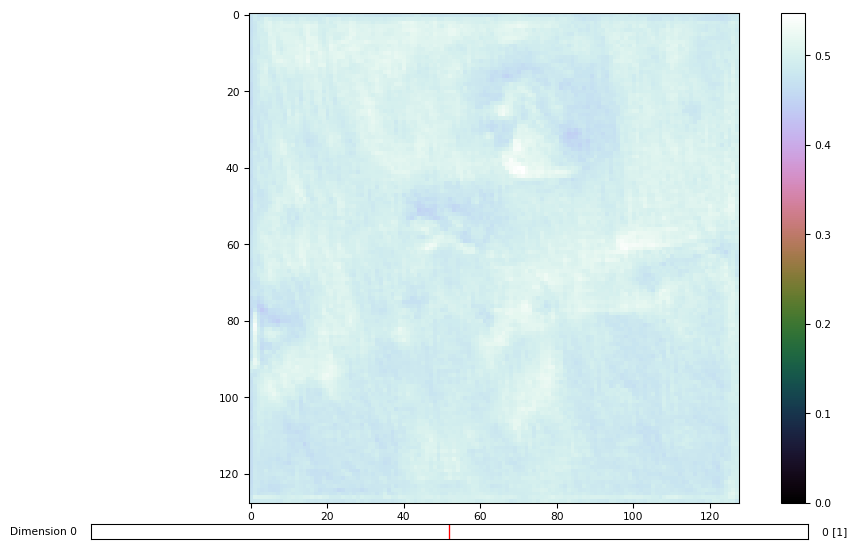

[0.69265579462051396, 0.48815207004547118, 0.14247348149617514]
Epoch 1/1
300/300 [==============================] - 1s     


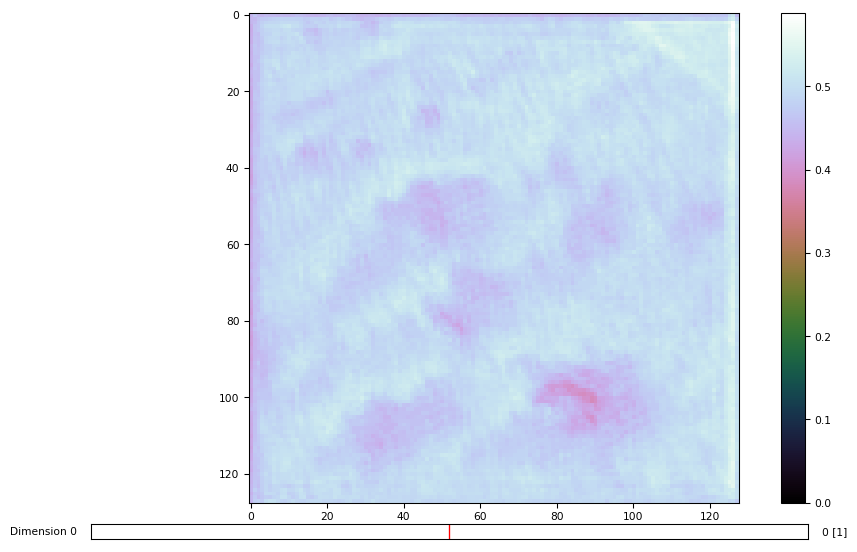

[0.64154229164123533, 0.75591431220372518, 0.096713057458400725]
Epoch 1/1
300/300 [==============================] - 1s     


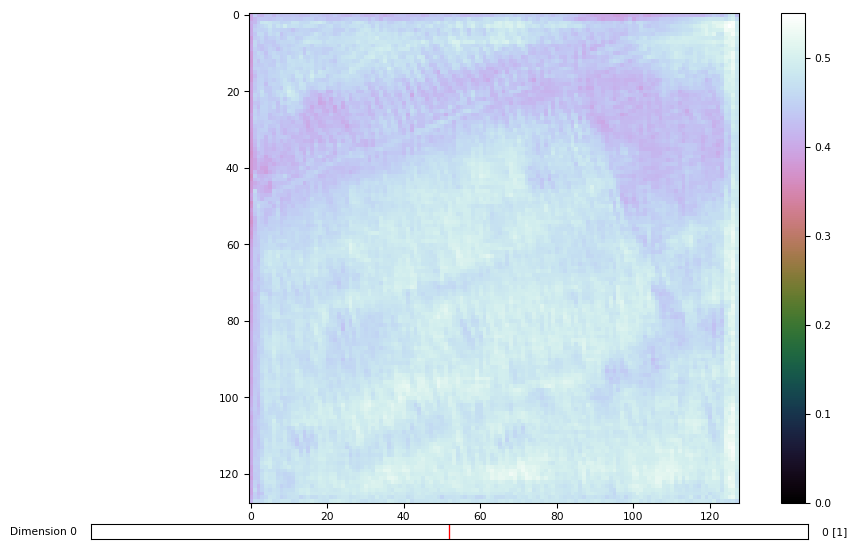

[0.57640488545099899, 0.86687439123789467, 0.091460112333297733]
Epoch 1/1
300/300 [==============================] - 1s     


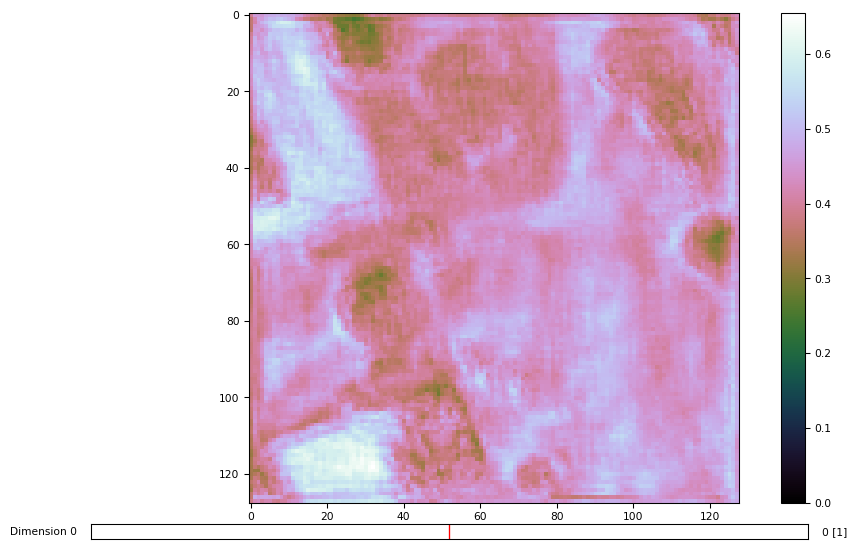

[0.50969738165537515, 0.89669432799021398, 0.078067698478698724]
Epoch 1/1
300/300 [==============================] - 1s     


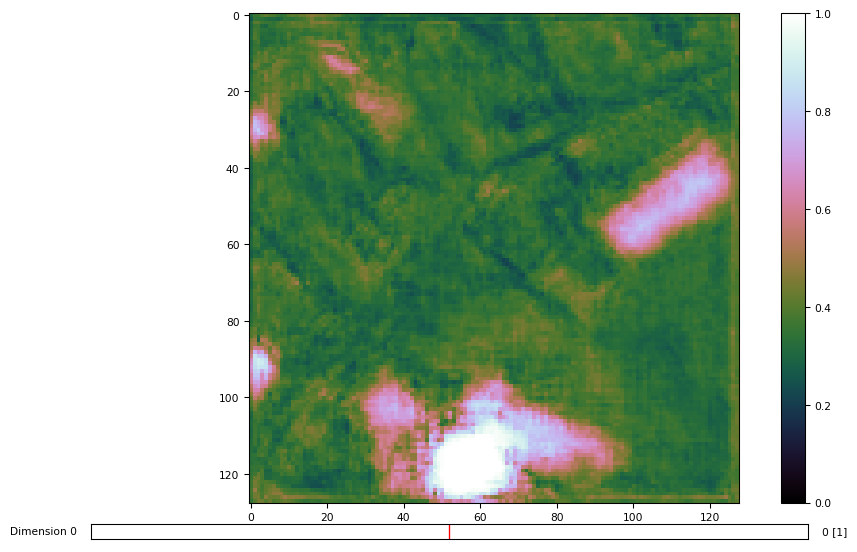

[0.47308117389678955, 0.87900939464569094, 0.098769262035687769]
Epoch 1/1
300/300 [==============================] - 1s     


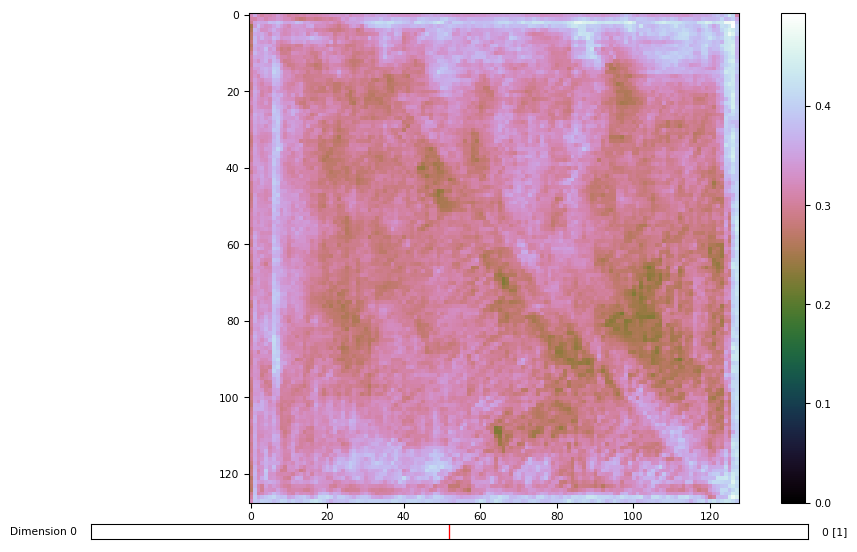

[0.41230907519658405, 0.89764689127604169, 0.11513197322686514]
Epoch 1/1
300/300 [==============================] - 1s     


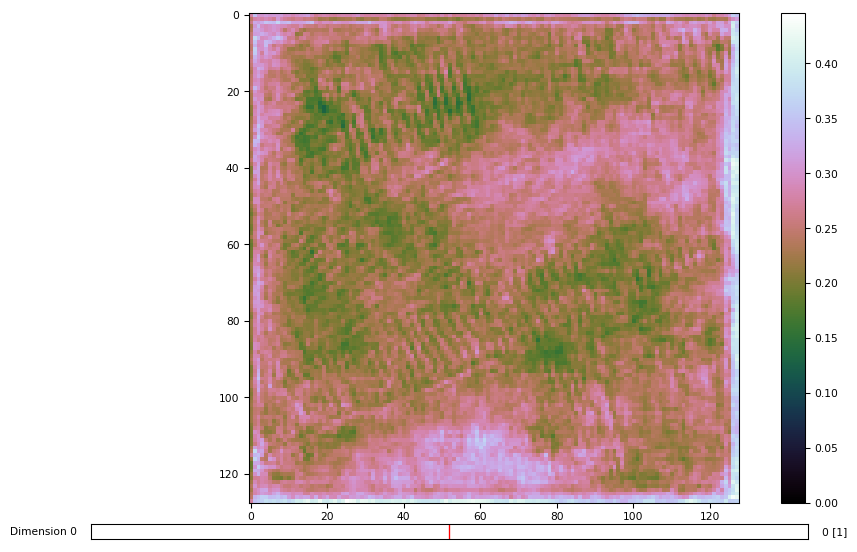

[0.36262124657630923, 0.91416318655014039, 0.12238217731316885]
Epoch 1/1
300/300 [==============================] - 1s     


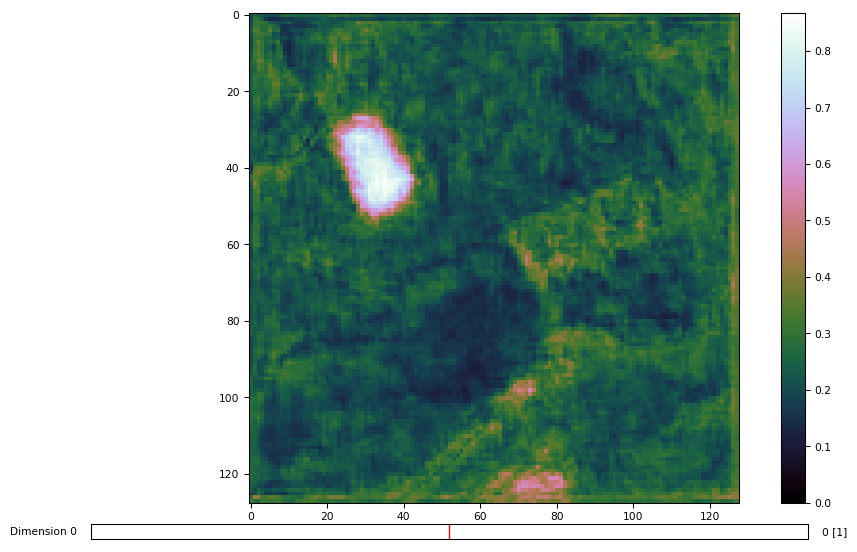

[0.35412174661954243, 0.89992635806401566, 0.17211623171965282]
Epoch 1/1
300/300 [==============================] - 1s     


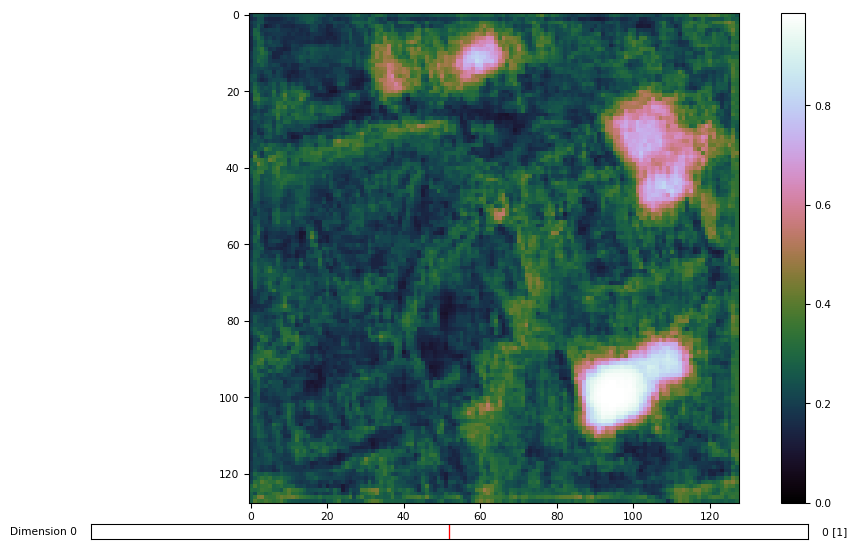

[0.31327874700228375, 0.91660989125569658, 0.19376670757929484]
Epoch 1/1
300/300 [==============================] - 1s     


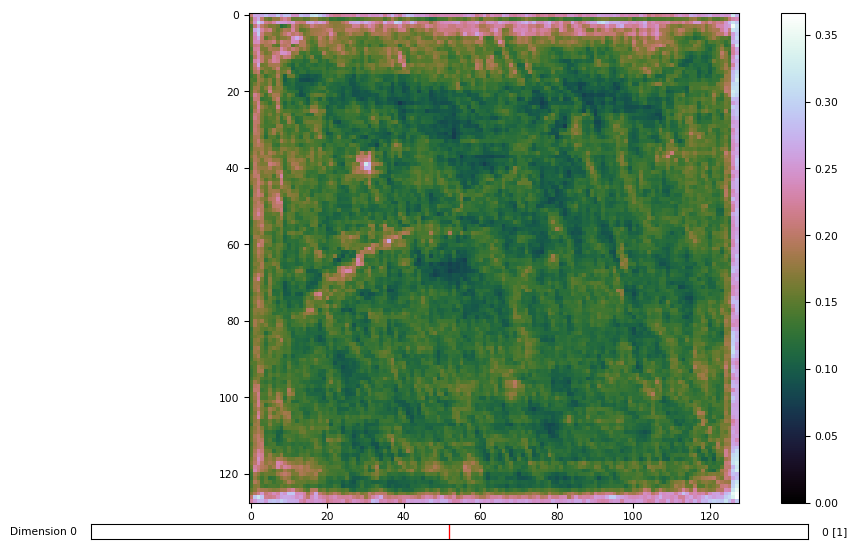

[0.31730083147684734, 0.90236021439234415, 0.19930254975954692]
Epoch 1/1
300/300 [==============================] - 1s     


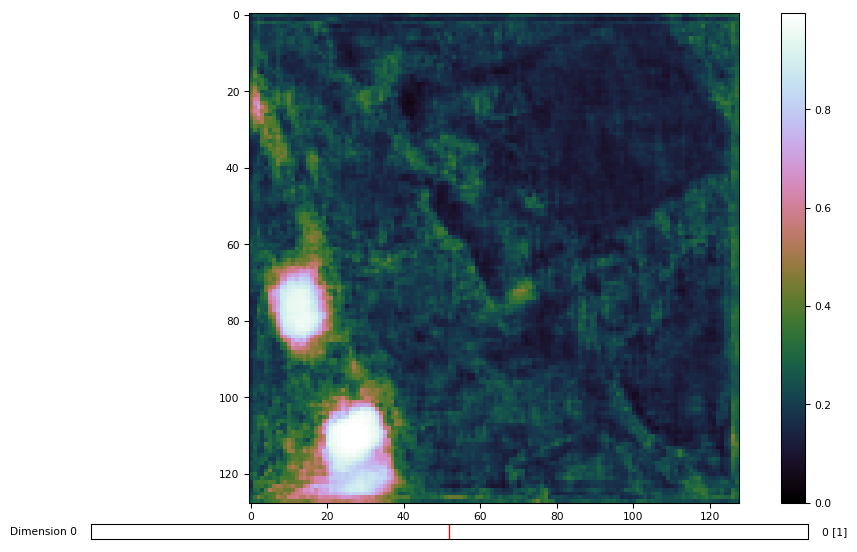

[0.27851434707641604, 0.92659787813822425, 0.21815233131249745]
Epoch 1/1
300/300 [==============================] - 1s     


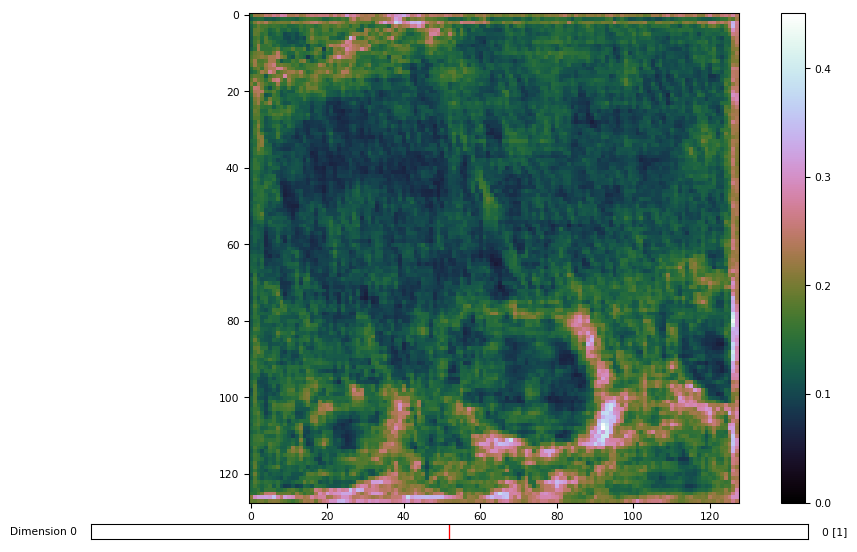

[0.29327307343482972, 0.91028217554092405, 0.23614136735598246]
Epoch 1/1
300/300 [==============================] - 1s     


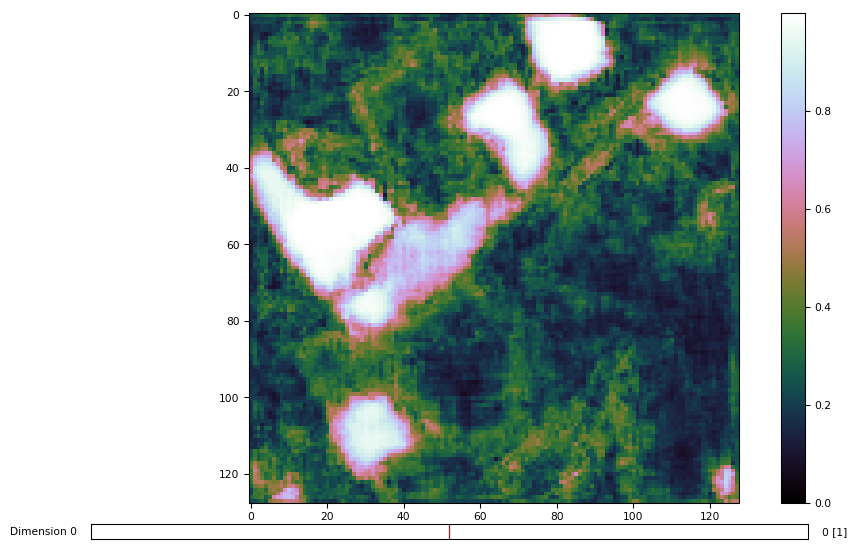

[0.27716838598251342, 0.91751708984375002, 0.23946582992871601]
Epoch 1/1
300/300 [==============================] - 1s     


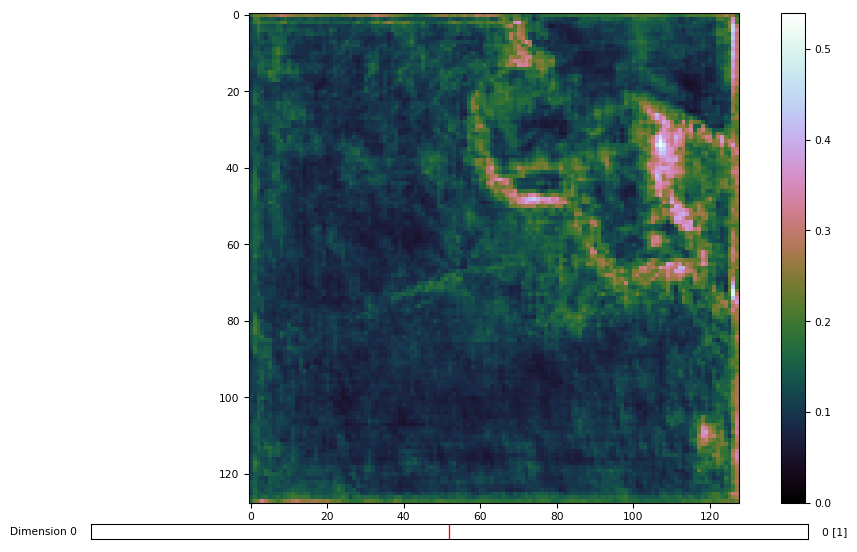

[0.27908488512039187, 0.91064269860585534, 0.24997791926066082]
Epoch 1/1
300/300 [==============================] - 1s     


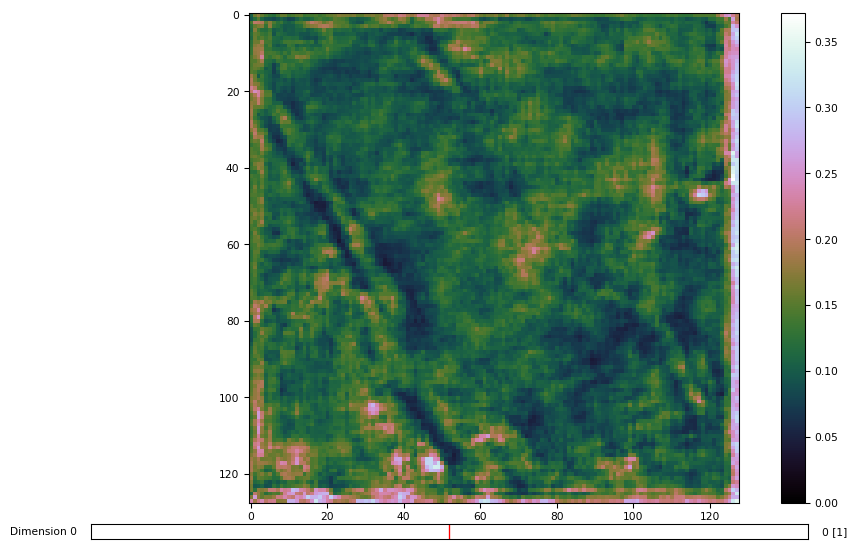

[0.26033125400543211, 0.92071715990702307, 0.27032872438430788]
Epoch 1/1
300/300 [==============================] - 1s     


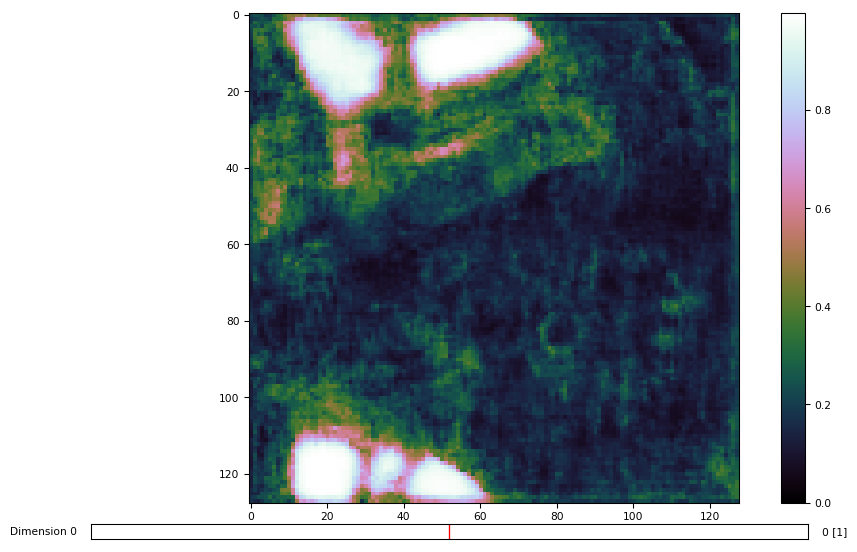

[0.25844220956166586, 0.91776854832967125, 0.25196590820948284]
Epoch 1/1
300/300 [==============================] - 1s     


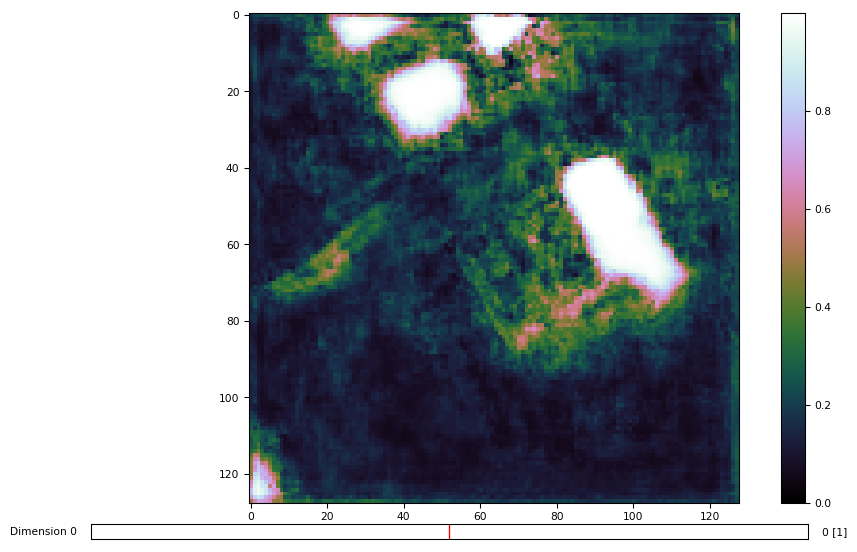

[0.24033250172932943, 0.92572631359100344, 0.27978820840517682]
Epoch 1/1
300/300 [==============================] - 1s     


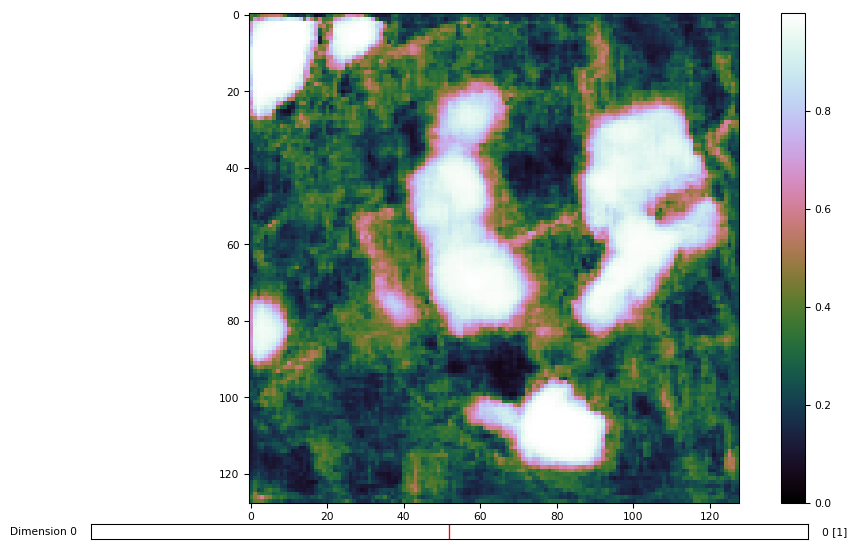

[0.24418305496374765, 0.9186081727345784, 0.2883308736483256]
Epoch 1/1
300/300 [==============================] - 1s     


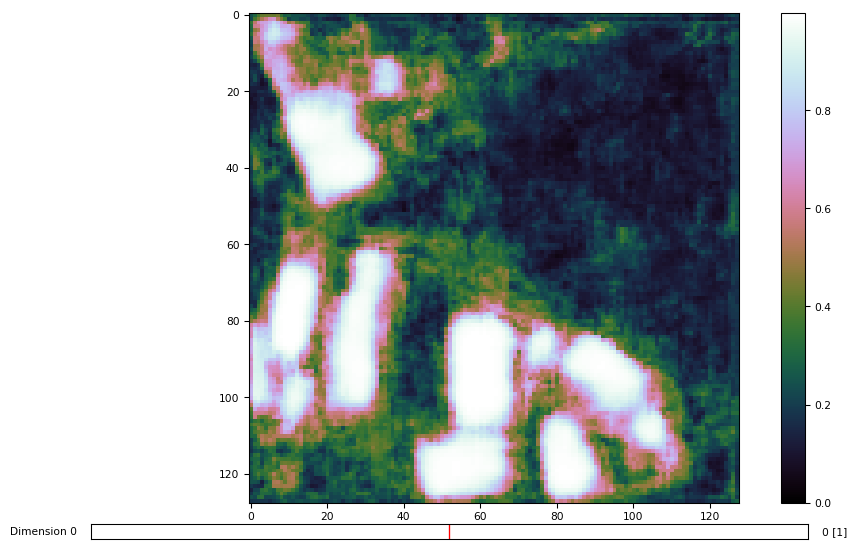

[0.23450226545333863, 0.92135783592859899, 0.30583977142969765]
Epoch 1/1
300/300 [==============================] - 1s     


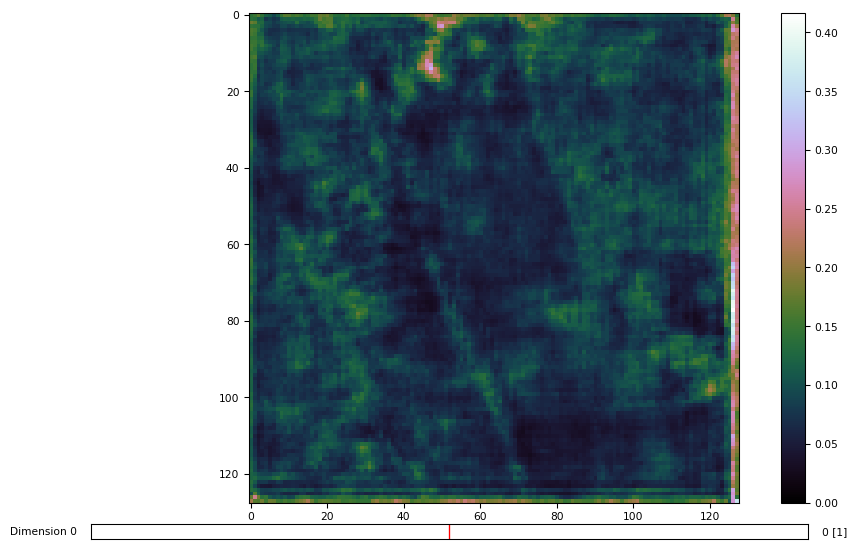

[0.24025937795639038, 0.91774657885233557, 0.299521355231603]
Epoch 1/1
300/300 [==============================] - 1s     


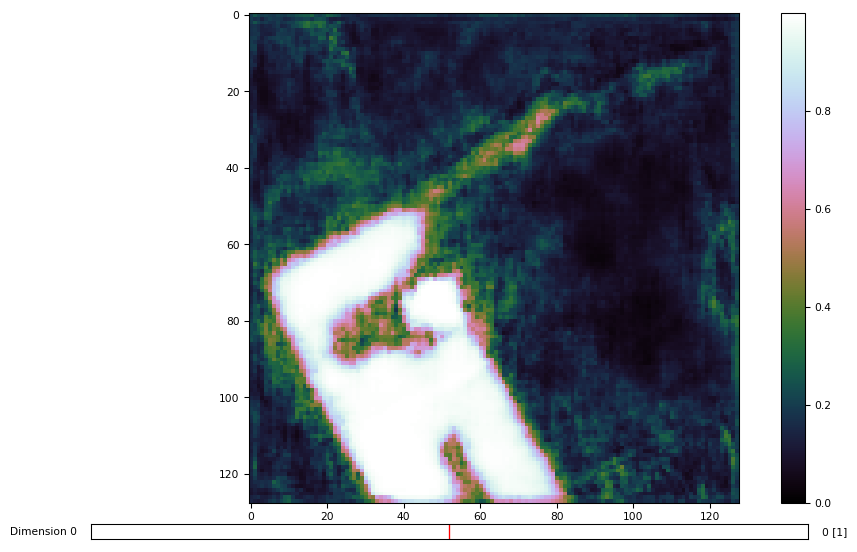

[0.21345874468485515, 0.93155720790227259, 0.29395114342371625]
Epoch 1/1
300/300 [==============================] - 1s     


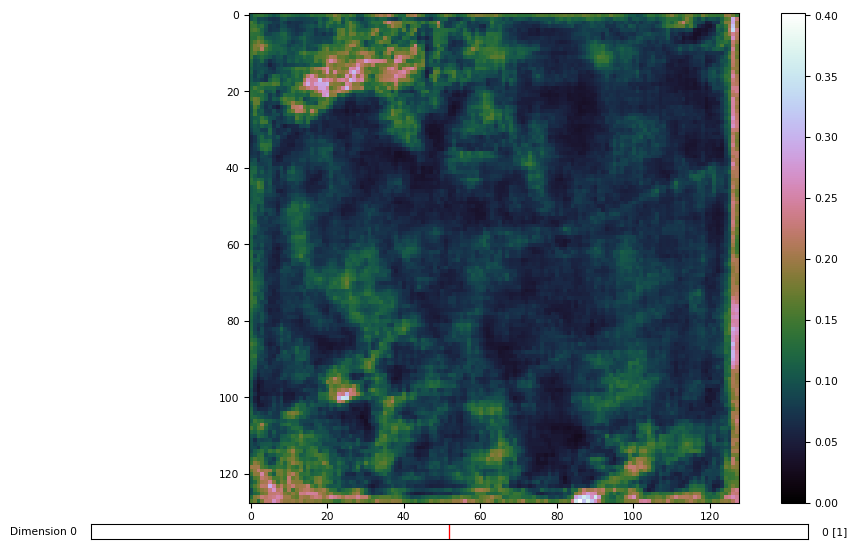

[0.22870921850204468, 0.92027831474939981, 0.29591265241305031]
Epoch 1/1
300/300 [==============================] - 1s     


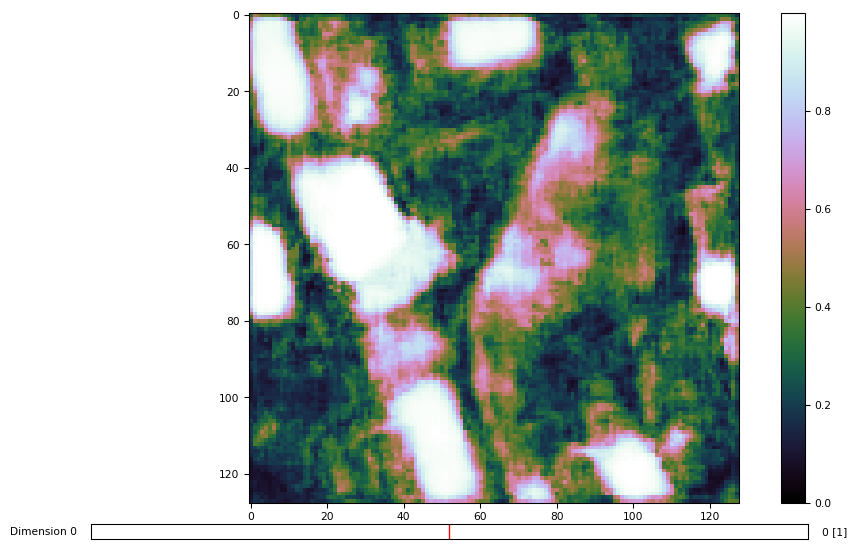

[0.1950085711479187, 0.93791055599848427, 0.30697143316268921]
Epoch 1/1
300/300 [==============================] - 1s     


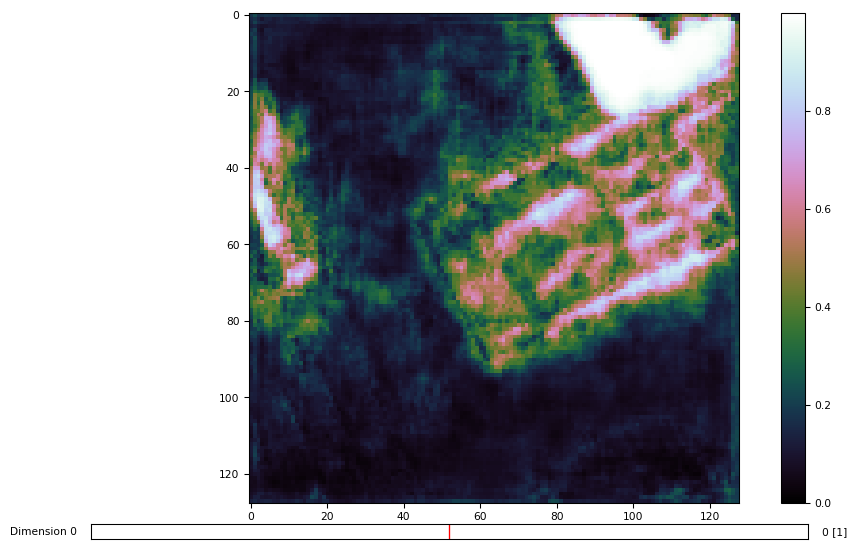

[0.21056890030701955, 0.92760314146677658, 0.3041318734486898]
Epoch 1/1
300/300 [==============================] - 1s     


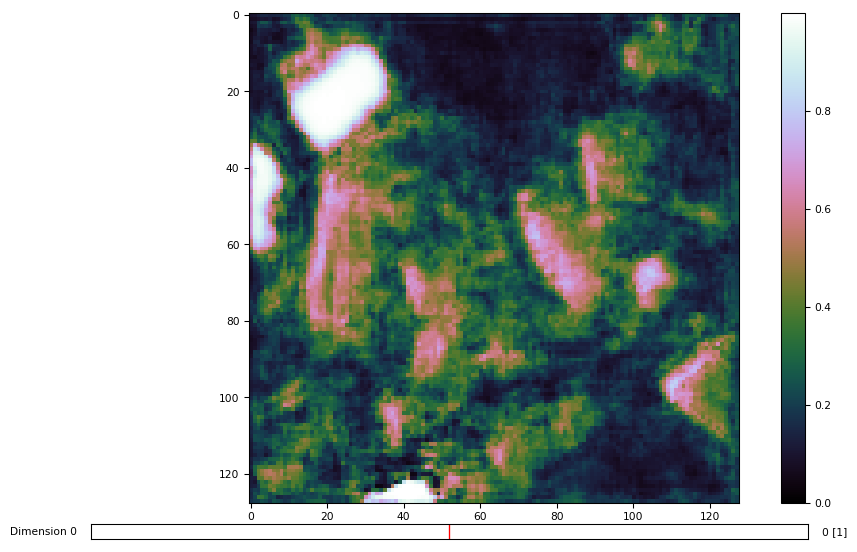

[0.22114188015460967, 0.92242694060007735, 0.33926030397415163]
Epoch 1/1
300/300 [==============================] - 1s     


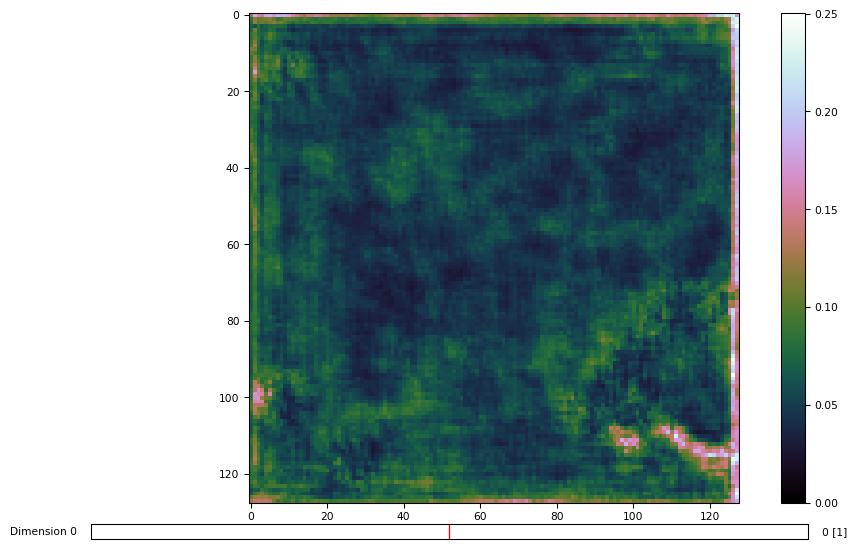

[0.19397072196006776, 0.93516436974207562, 0.33272463480631509]
Epoch 1/1
300/300 [==============================] - 1s     


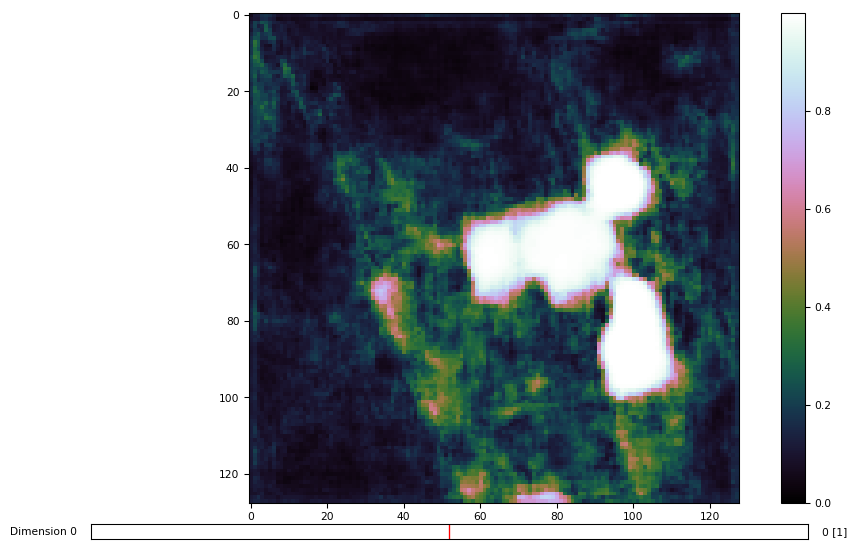

[0.21740699410438538, 0.92196288267771398, 0.34717913667360939]
Epoch 1/1
300/300 [==============================] - 1s     


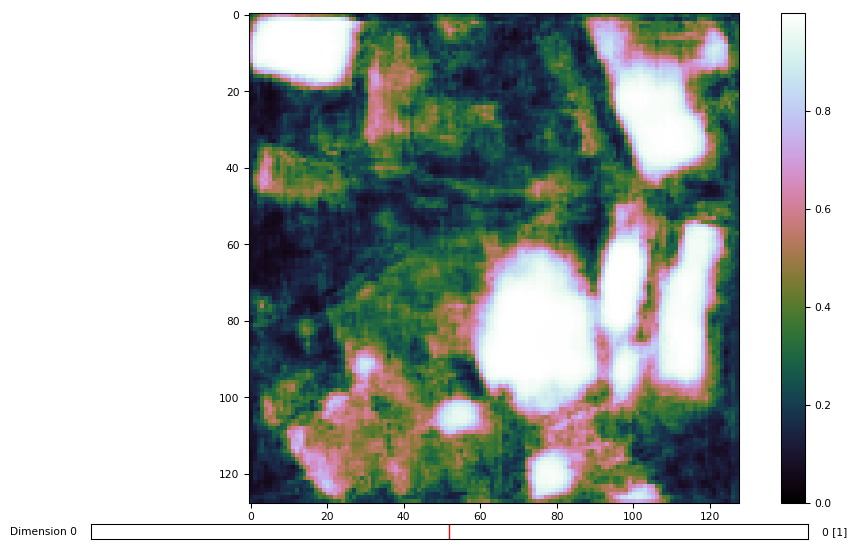

[0.21338468631108601, 0.92211995045344031, 0.33905770818392433]
Epoch 1/1
300/300 [==============================] - 1s     


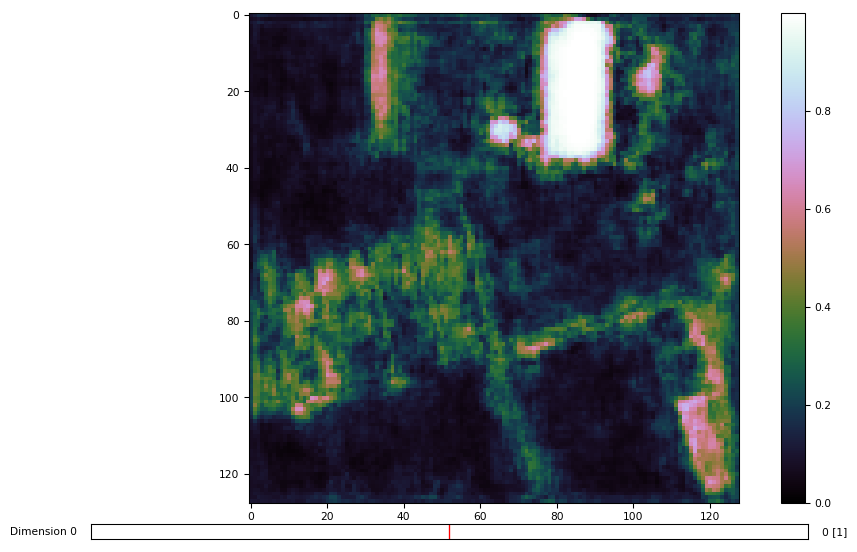

[0.19722145477930705, 0.93035521109898889, 0.36041296998659772]
Epoch 1/1
300/300 [==============================] - 1s     


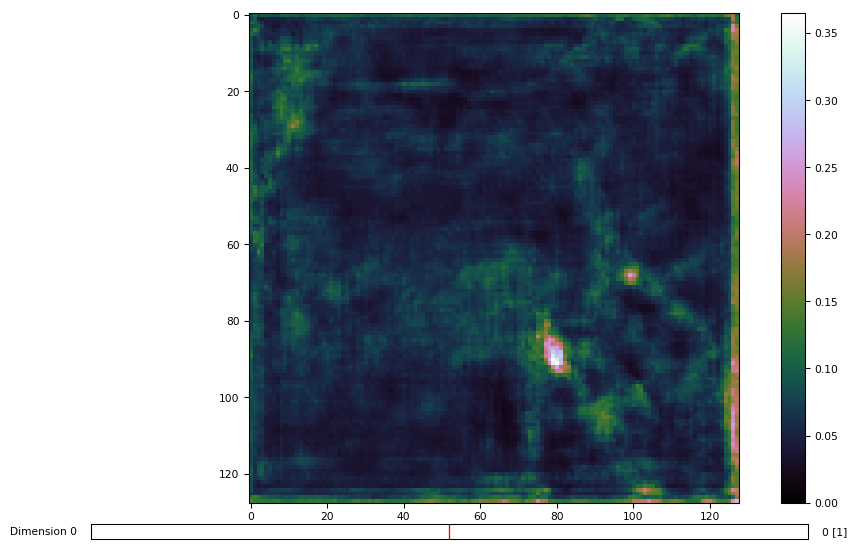

[0.2009819616874059, 0.92847676038742066, 0.37926881750424701]
Epoch 1/1
300/300 [==============================] - 1s     


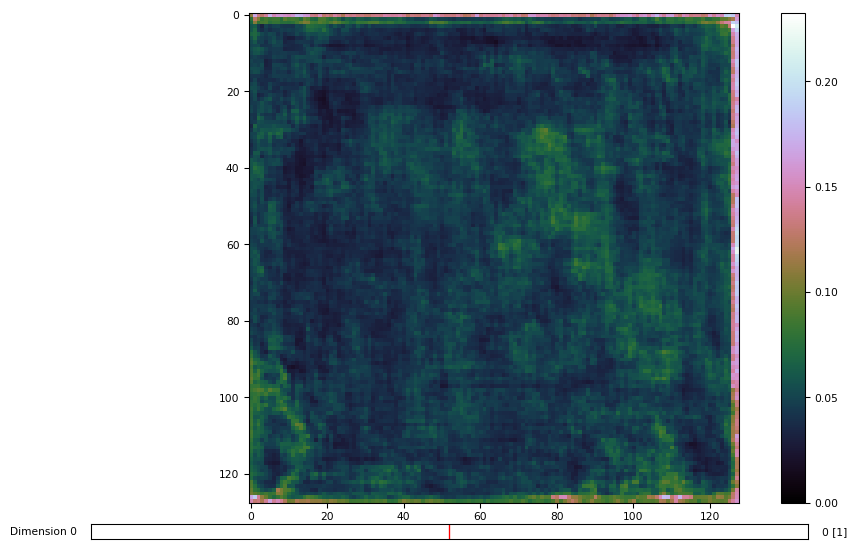

[0.18532640059789021, 0.93558225949605311, 0.35763140082359313]
Epoch 1/1
300/300 [==============================] - 1s     


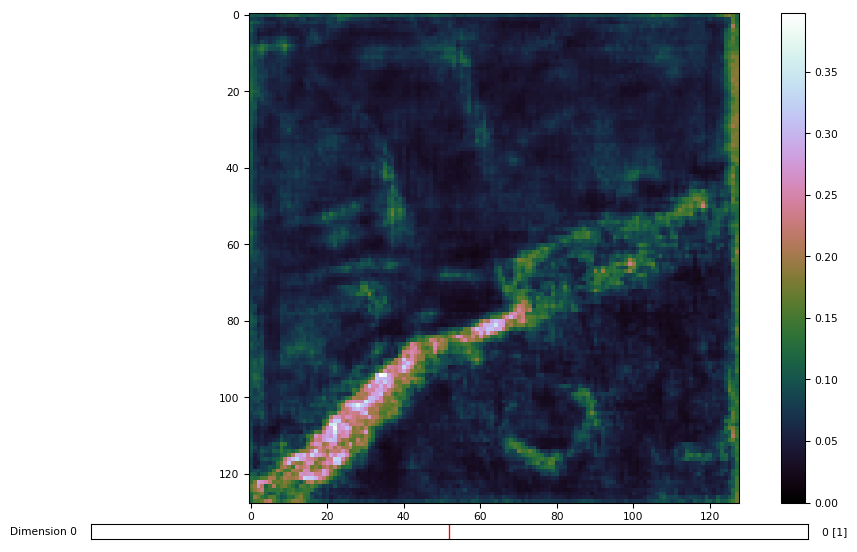

[0.19562133967876436, 0.92750894943873086, 0.37341156284014382]
Epoch 1/1
300/300 [==============================] - 1s     


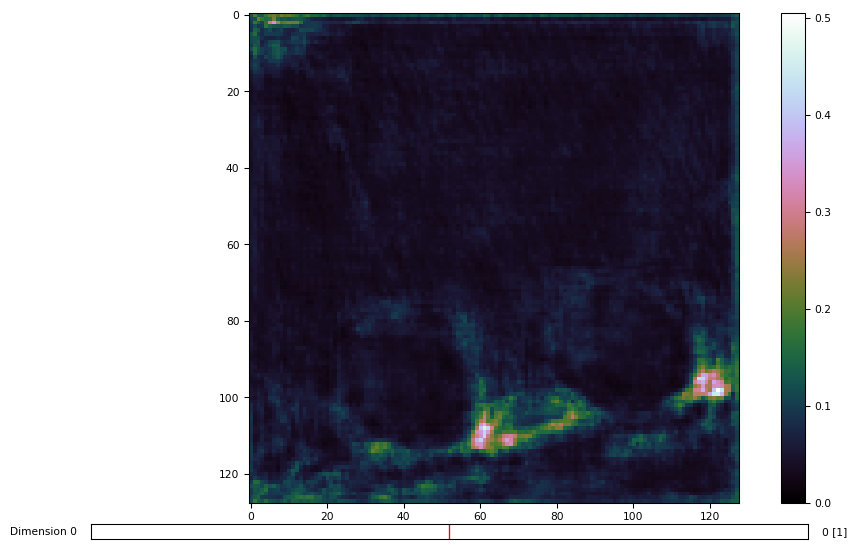

[0.18856574336687723, 0.93166971286137901, 0.38501194159189861]
Epoch 1/1
300/300 [==============================] - 1s     


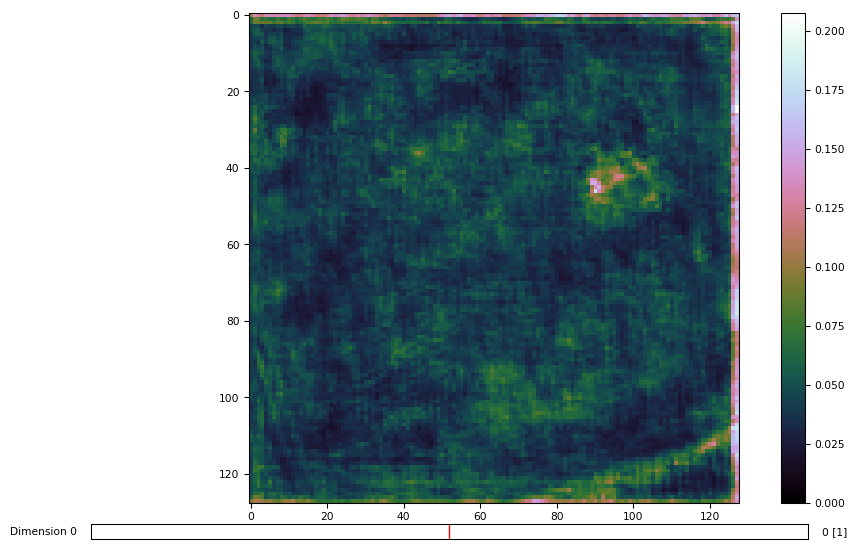

[0.18194489578406017, 0.93519935607910154, 0.39479739268620812]
Epoch 1/1
300/300 [==============================] - 1s     


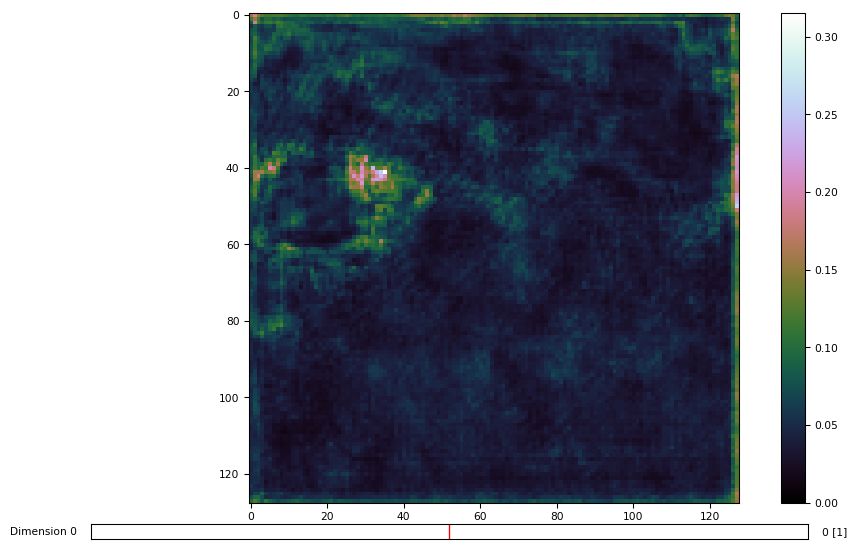

[0.1800651369492213, 0.93637918949127197, 0.37367223302523295]
Epoch 1/1
300/300 [==============================] - 1s     


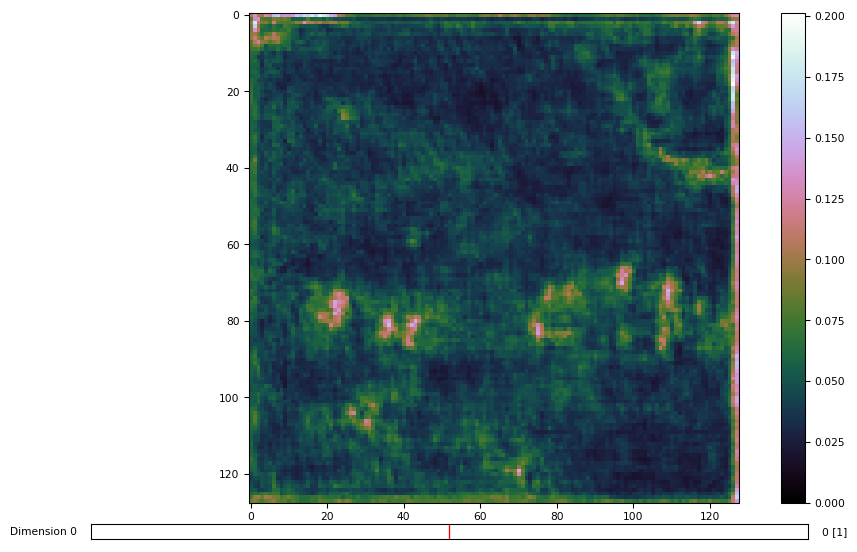

[0.18626171996196111, 0.93117571194966631, 0.37533261497815451]
Epoch 1/1
300/300 [==============================] - 1s     


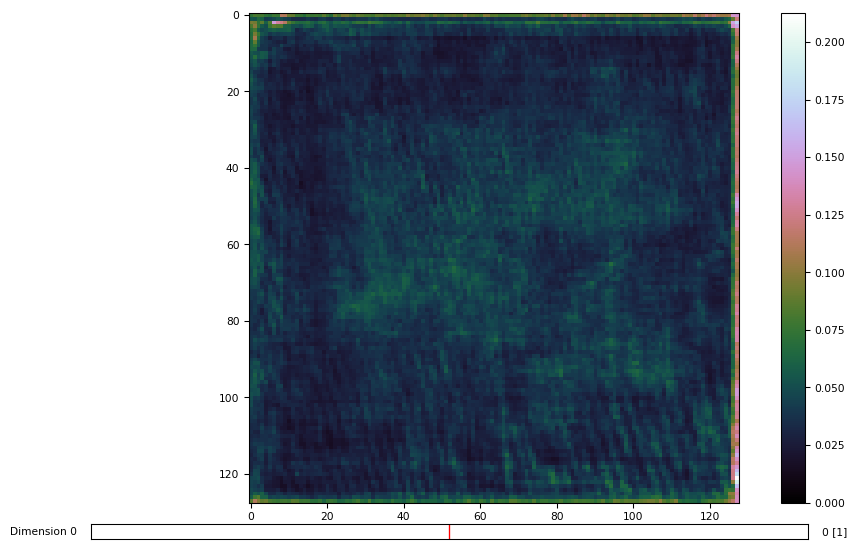

[0.17542945742607116, 0.937129111289978, 0.40823636531829832]
Epoch 1/1
300/300 [==============================] - 1s     


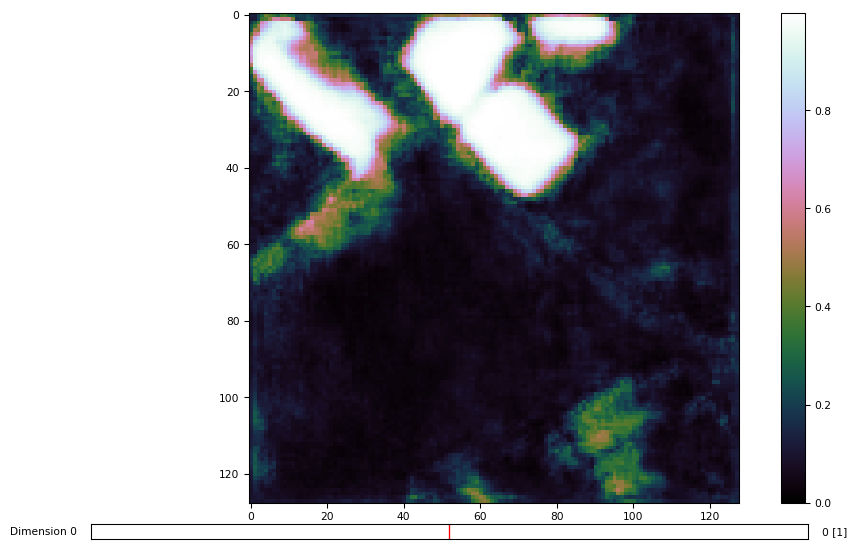

[0.19171338876088459, 0.92662474870681766, 0.40754711389541626]
Epoch 1/1
 870/1000 [=========================>....] - ETA: 2s - loss: 0.1949 - acc: 0.9264 - iou_metric: 0.3913

In [ ]:
inputs = Input((128,128,3))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), padding='same')(bn1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
conv1 = Conv2D(32, (3, 3), padding='same')(act1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)

conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
conv2 = Conv2D(64, (3, 3), padding='same')(act2)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)

conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
conv3 = Conv2D(128, (3, 3), padding='same')(act3)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)

conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
conv4 = Conv2D(256, (3, 3), padding='same')(act4)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
pool4 = MaxPooling2D(pool_size=(2, 2))(act4)

conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
conv5 = Conv2D(512, (3, 3), padding='same')(act5)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)

up6 = concatenate([UpSampling2D(size=(2, 2))(act5), act4], axis=3)
conv6 = Conv2D(256, (3, 3), padding='same')(up6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
conv6 = Conv2D(256, (3, 3), padding='same')(act6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)

up7 = concatenate([UpSampling2D(size=(2, 2))(act6), act3], axis =3 )
conv7 = Conv2D(128, (3, 3), padding='same')(up7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)
conv7 = Conv2D(128, (3, 3), padding='same')(act7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)

up8 = concatenate([UpSampling2D(size=(2, 2))(act7), act2], axis=3)
conv8 = Conv2D(64, (3, 3), padding='same')(up8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)
conv8 = Conv2D(64, (3, 3), padding='same')(act8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)

up9 = concatenate([UpSampling2D(size=(2, 2))(act8), act1], axis=3)
conv9 = Conv2D(32, (3, 3), padding='same')(up9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)
conv9 = Conv2D(32, (3, 3), padding='same')(act9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(act9)

model = Model(inputs=inputs, outputs=conv10, name = 'Unet')
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ 'accuracy'])
print(model.summary())

optimizer = keras.optimizers.SGD(lr=0.003)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', iou_metric])
batch_size = 30
cls = 0
scale = 1

for i in range (100):
    prediction = None
    for j in range (1):
        X, Y = BatchGeneratorFly(1000).generate(imgs, masks, 0, 1)
        model.fit(X,Y,verbose=True, batch_size=batch_size)
    
    X, Y = BatchGeneratorFly(300).generate(imgs, masks, 0, 1)
    loss = model.evaluate(X,Y)  
    prediction = model.predict(np.array([X[0]]))
    tiff.imshow(prediction[0])
    plt.show()
    print(loss)

# training_generator = BatchGeneratorFly(batch_size = batch_size)
# training_generator.masks_analysis(masks)
# generator_1 = BatchGeneratorFly(batch_size = batch_size).generate(imgs, masks, cls,'Dataset/DSTL/fly2/debug/train/', scale)

# #generator_2 = training_generator.generate(imgs, masks, cls, scale)
# validation_generator = BatchGeneratorFly(batch_size = batch_size-15)
# #validation_generator.masks_analysis(masks)
# generator_2 = BatchGeneratorFly(batch_size = batch_size-15).generate(imgs, masks, cls,'Dataset/DSTL/fly2/debug/val/', scale)

# #validation_generator = BatchGeneratorFly(DF, GS, batch_size = batch_size).generate(imgs, masks, cls, scale)

# model.fit_generator(generator = generator_1,
#                     steps_per_epoch =100,# len(X_train)//batch_size,
#                     validation_data = generator_2,
#                     validation_steps =10,# len(X_train)//batch_size, 
#                     verbose = True,epochs= 10)

In [16]:
classes = [0, 1,4,5]
scales = [1, 0.5]
histories = {}

for cls in classes:
    for scale in scales:

        # Unet v1.1 with batchnorms
        inputs = Input((128,128,3))
        bn1 = BatchNormalization()(inputs)
        conv1 = Conv2D(32, (3, 3), padding='same')(bn1)
        bn1 = BatchNormalization()(conv1)
        act1 = Activation('relu')(bn1)
        conv1 = Conv2D(32, (3, 3), padding='same')(act1)
        bn1 = BatchNormalization()(conv1)
        act1 = Activation('relu')(bn1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(act1)

        conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
        bn2 = BatchNormalization()(conv2)
        act2 = Activation('relu')(bn2)
        conv2 = Conv2D(64, (3, 3), padding='same')(act2)
        bn2 = BatchNormalization()(conv2)
        act2 = Activation('relu')(bn2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(act2)

        conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
        bn3 = BatchNormalization()(conv3)
        act3 = Activation('relu')(bn3)
        conv3 = Conv2D(128, (3, 3), padding='same')(act3)
        bn3 = BatchNormalization()(conv3)
        act3 = Activation('relu')(bn3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(act3)

        conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
        bn4 = BatchNormalization()(conv4)
        act4 = Activation('relu')(bn4)
        conv4 = Conv2D(256, (3, 3), padding='same')(act4)
        bn4 = BatchNormalization()(conv4)
        act4 = Activation('relu')(bn4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(act4)

        conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
        bn5 = BatchNormalization()(conv5)
        act5 = Activation('relu')(bn5)
        conv5 = Conv2D(512, (3, 3), padding='same')(act5)
        bn5 = BatchNormalization()(conv5)
        act5 = Activation('relu')(bn5)

        up6 = concatenate([UpSampling2D(size=(2, 2))(act5), act4], axis=3)
        conv6 = Conv2D(256, (3, 3), padding='same')(up6)
        bn6 = BatchNormalization()(conv6)
        act6 = Activation('relu')(bn6)
        conv6 = Conv2D(256, (3, 3), padding='same')(act6)
        bn6 = BatchNormalization()(conv6)
        act6 = Activation('relu')(bn6)

        up7 = concatenate([UpSampling2D(size=(2, 2))(act6), act3], axis =3 )
        conv7 = Conv2D(128, (3, 3), padding='same')(up7)
        bn7 = BatchNormalization()(conv7)
        act7 = Activation('relu')(bn7)
        conv7 = Conv2D(128, (3, 3), padding='same')(act7)
        bn7 = BatchNormalization()(conv7)
        act7 = Activation('relu')(bn7)

        up8 = concatenate([UpSampling2D(size=(2, 2))(act7), act2], axis=3)
        conv8 = Conv2D(64, (3, 3), padding='same')(up8)
        bn8 = BatchNormalization()(conv8)
        act8 = Activation('relu')(bn8)
        conv8 = Conv2D(64, (3, 3), padding='same')(act8)
        bn8 = BatchNormalization()(conv8)
        act8 = Activation('relu')(bn8)

        up9 = concatenate([UpSampling2D(size=(2, 2))(act8), act1], axis=3)
        conv9 = Conv2D(32, (3, 3), padding='same')(up9)
        bn9 = BatchNormalization()(conv9)
        act9 = Activation('relu')(bn9)
        conv9 = Conv2D(32, (3, 3), padding='same')(act9)
        bn9 = BatchNormalization()(conv9)
        act9 = Activation('relu')(bn9)

        conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(act9)

        model = Model(inputs=inputs, outputs=conv10, name = 'Unet')
        #model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ 'accuracy'])
        print(model.summary())

        optimizer = keras.optimizers.SGD(lr=0.003)
        model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=['accuracy', iou_metric])
        batch_size = 35
        # cls = 0
        # scale = 1
        training_generator = BatchGeneratorFly(batch_size = batch_size)
        training_generator.masks_analysis(masks)
        generator_1 = BatchGeneratorFly(batch_size = batch_size).generate(imgs, masks, cls,'Dataset/DSTL/fly2/debug/train/', scale)
        
        #generator_2 = training_generator.generate(imgs, masks, cls, scale)
        validation_generator = BatchGeneratorFly(batch_size = batch_size-15)
        #validation_generator.masks_analysis(masks)
        generator_2 = BatchGeneratorFly(batch_size = batch_size-15).generate(imgs, masks, cls,'Dataset/DSTL/fly2/debug/val/', scale)
        
        #validation_generator = BatchGeneratorFly(DF, GS, batch_size = batch_size).generate(imgs, masks, cls, scale)

        model.fit_generator(generator = generator_1,
                            steps_per_epoch =100,# len(X_train)//batch_size,
                            validation_data = generator_2,
                            validation_steps =10,# len(X_train)//batch_size, 
                            verbose = True,epochs= 10)
        key = 'NN_histories/1___'+str(cls) + '_'+str(scale)
        #print(key)
        histories[key] = history.history
        with open (key+'.pkl', 'wb') as f:
            pickle.dump(history.history, f)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_134 (BatchNo (None, 128, 128, 3)   12          input_8[0][0]                    
____________________________________________________________________________________________________
conv2d_134 (Conv2D)              (None, 128, 128, 32)  896         batch_normalization_134[0][0]    
____________________________________________________________________________________________________
batch_normalization_135 (BatchNo (None, 128, 128, 32)  128         conv2d_134[0][0]                 
___________________________________________________________________________________________

100/100 [==============================] - 83s - loss: 0.8498 - acc: 0.8336 - iou_metric: 0.1192 - val_loss: 0.8729 - val_acc: 0.1294 - val_iou_metric: 0.1606
Epoch 2/10
 64/100 [==================>...........] - ETA: 24s - loss: 0.7637 - acc: 0.8664 - iou_metric: 0.2587

KeyboardInterrupt: 

['Dataset/DSTL/fly2/debug/train/masks/27.tif', 'Dataset/DSTL/fly2/debug/train/masks/29.tif', 'Dataset/DSTL/fly2/debug/train/masks/2.tif', 'Dataset/DSTL/fly2/debug/train/masks/11.tif', 'Dataset/DSTL/fly2/debug/train/masks/25.tif', 'Dataset/DSTL/fly2/debug/train/masks/6.tif', 'Dataset/DSTL/fly2/debug/train/masks/31.tif', 'Dataset/DSTL/fly2/debug/train/masks/8.tif', 'Dataset/DSTL/fly2/debug/train/masks/23.tif', 'Dataset/DSTL/fly2/debug/train/masks/16.tif', 'Dataset/DSTL/fly2/debug/train/masks/17.tif', 'Dataset/DSTL/fly2/debug/train/masks/33.tif', 'Dataset/DSTL/fly2/debug/train/masks/22.tif', 'Dataset/DSTL/fly2/debug/train/masks/28.tif', 'Dataset/DSTL/fly2/debug/train/masks/18.tif', 'Dataset/DSTL/fly2/debug/train/masks/10.tif', 'Dataset/DSTL/fly2/debug/train/masks/14.tif', 'Dataset/DSTL/fly2/debug/train/masks/24.tif', 'Dataset/DSTL/fly2/debug/train/masks/9.tif', 'Dataset/DSTL/fly2/debug/train/masks/21.tif', 'Dataset/DSTL/fly2/debug/train/masks/34.tif', 'Dataset/DSTL/fly2/debug/train/masks/

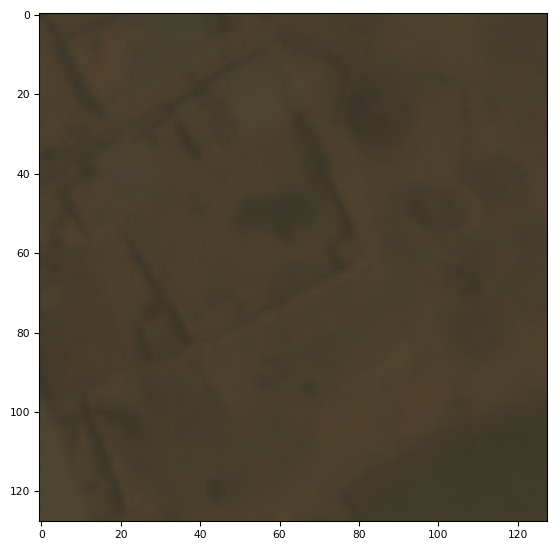

/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


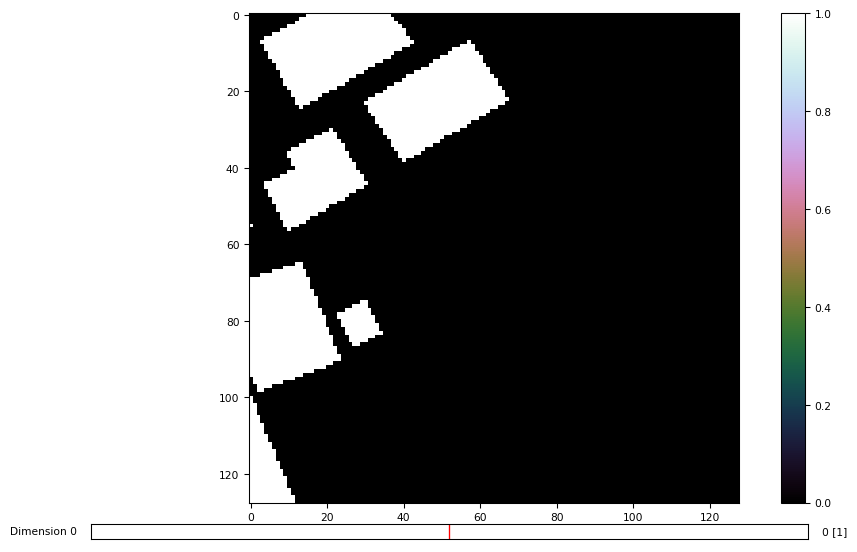

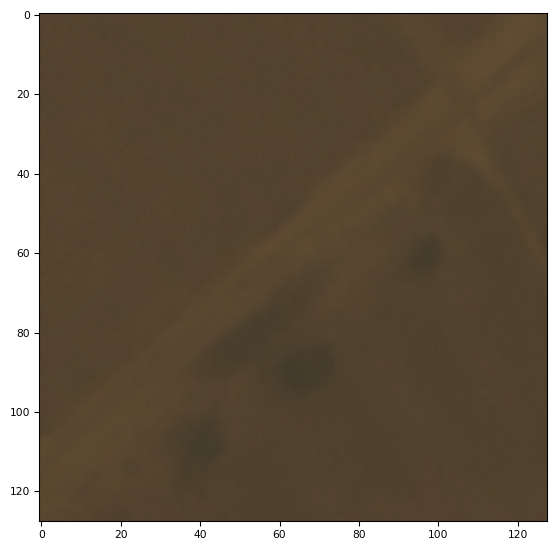

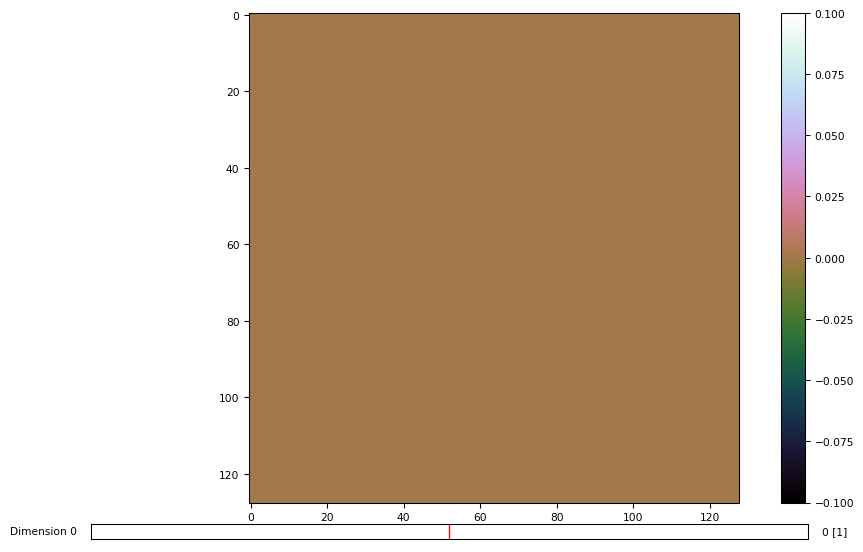

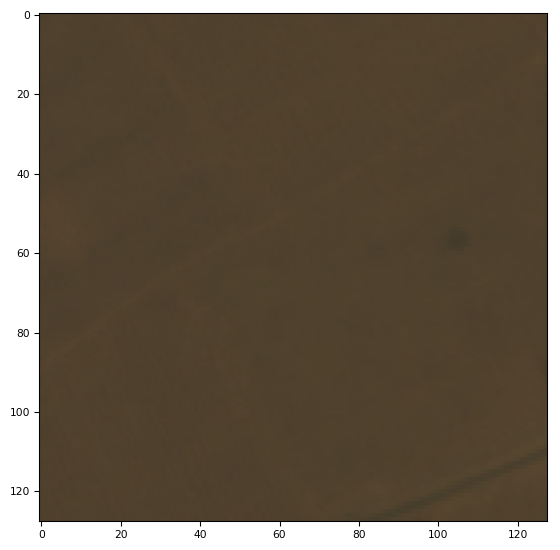

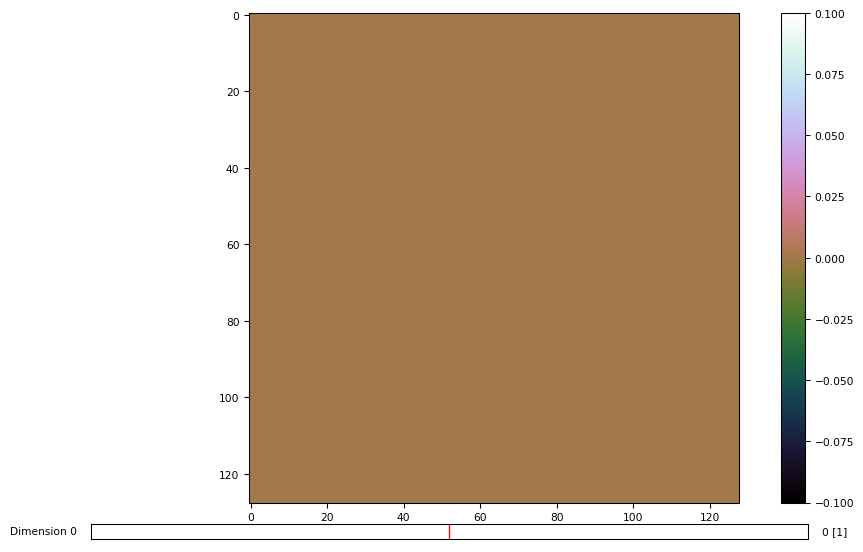

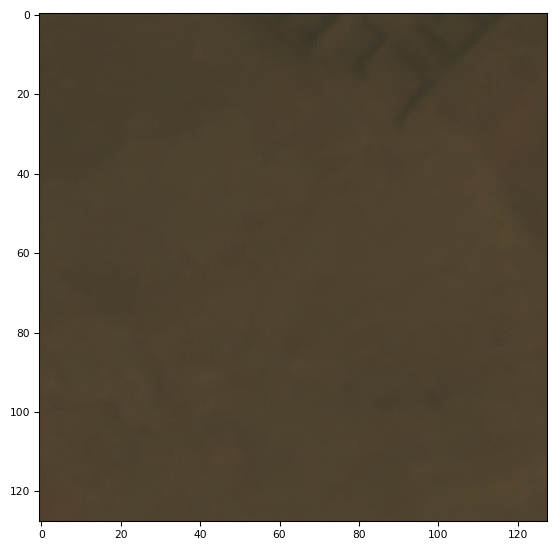

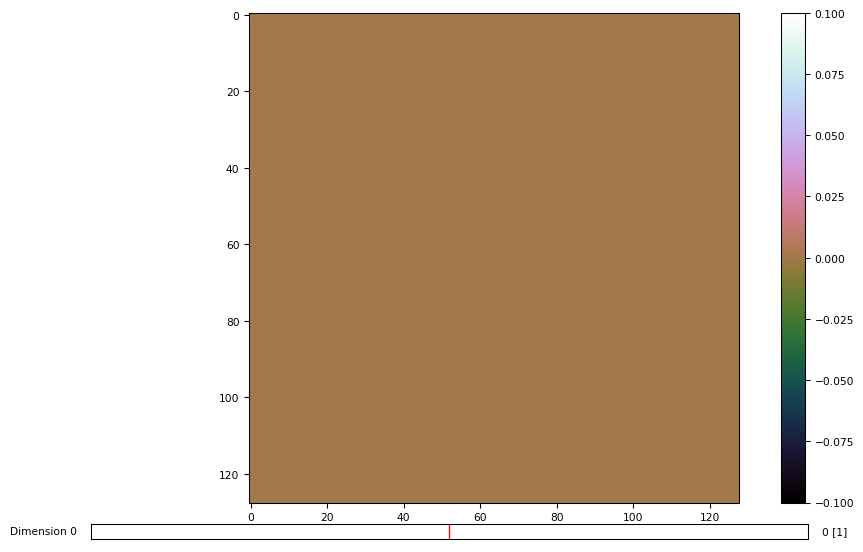

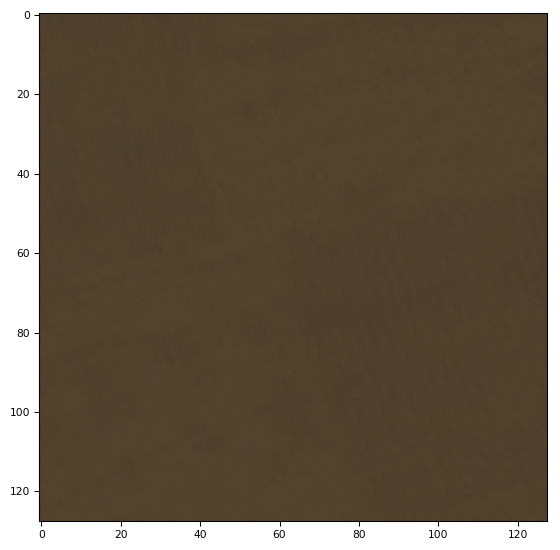

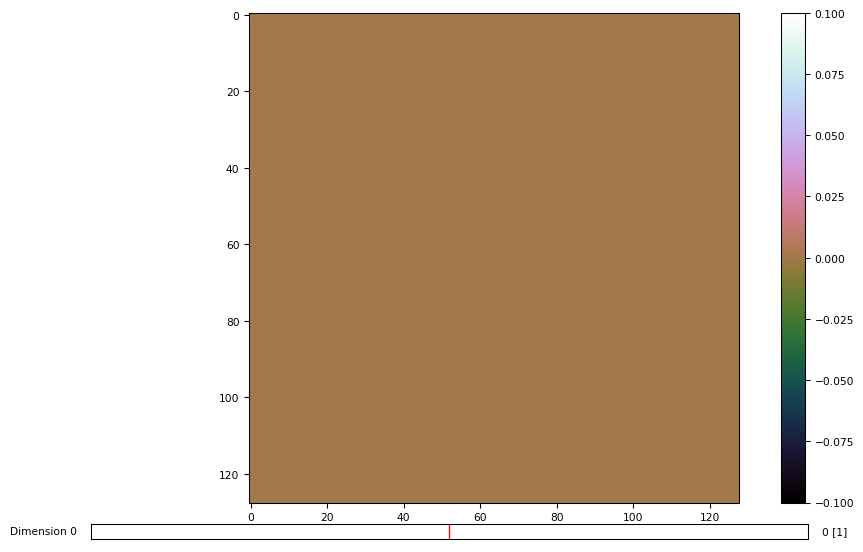

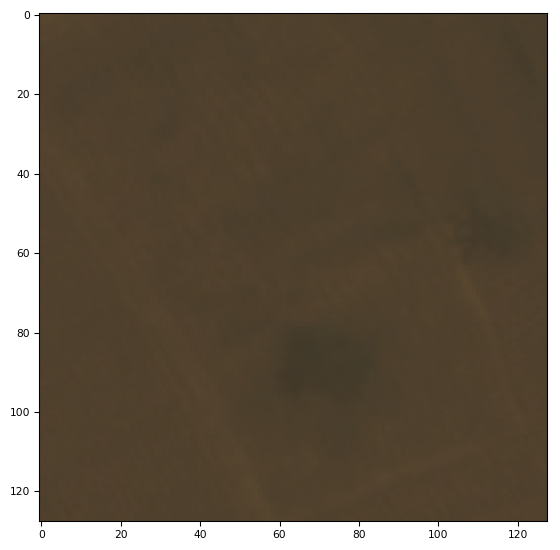

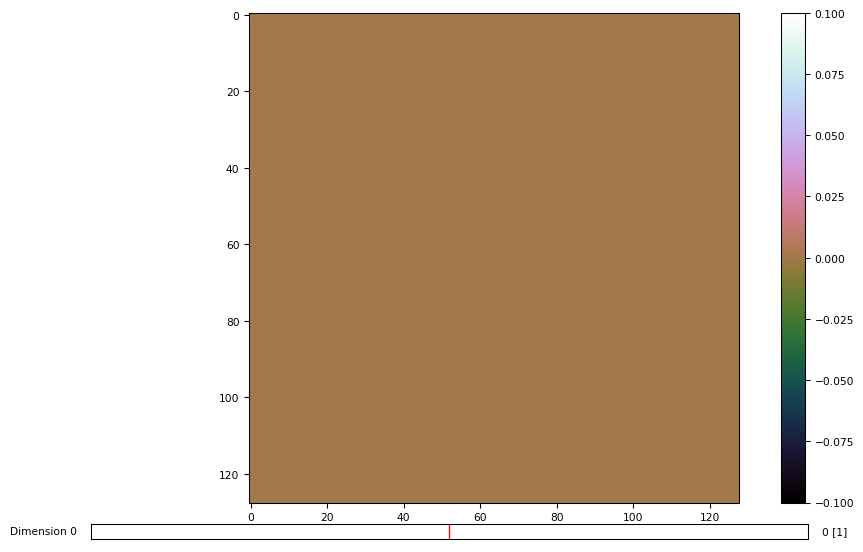

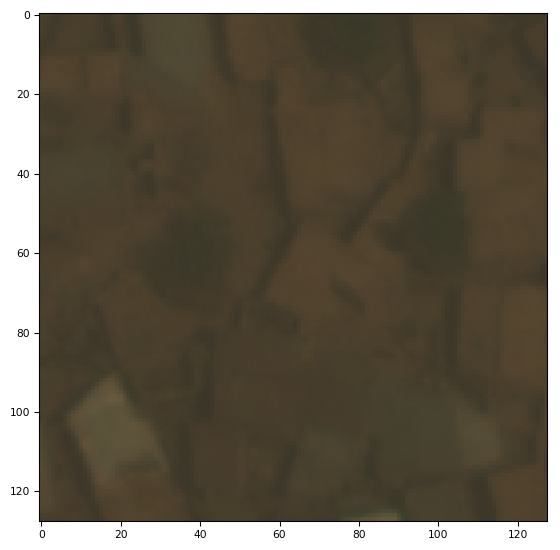

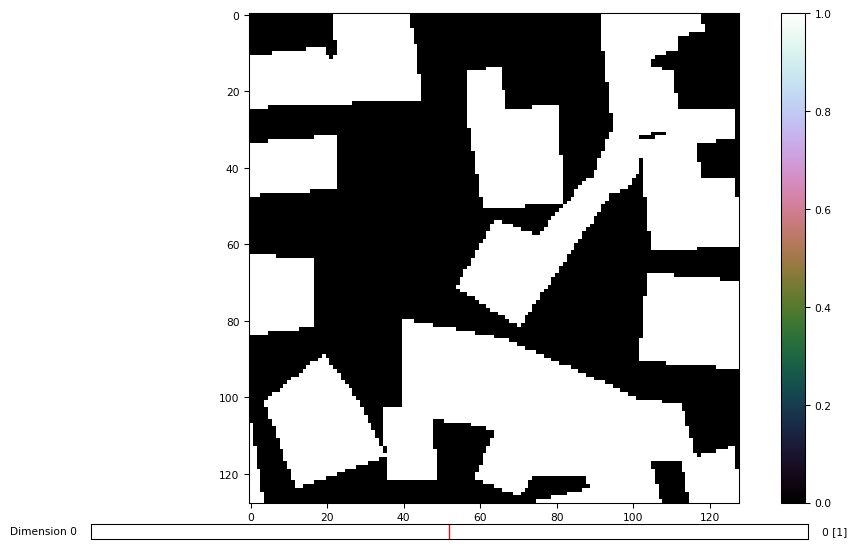

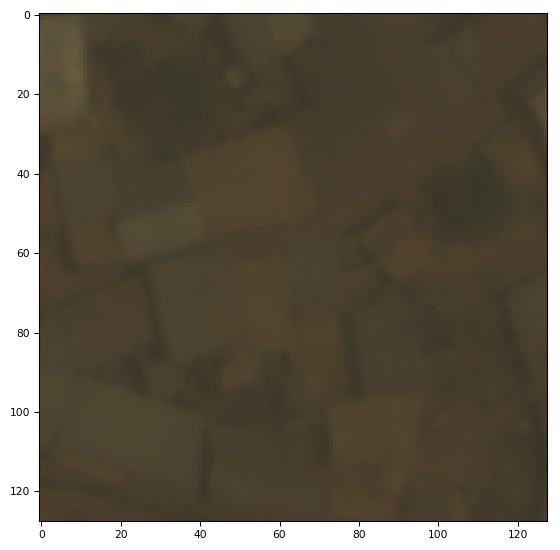

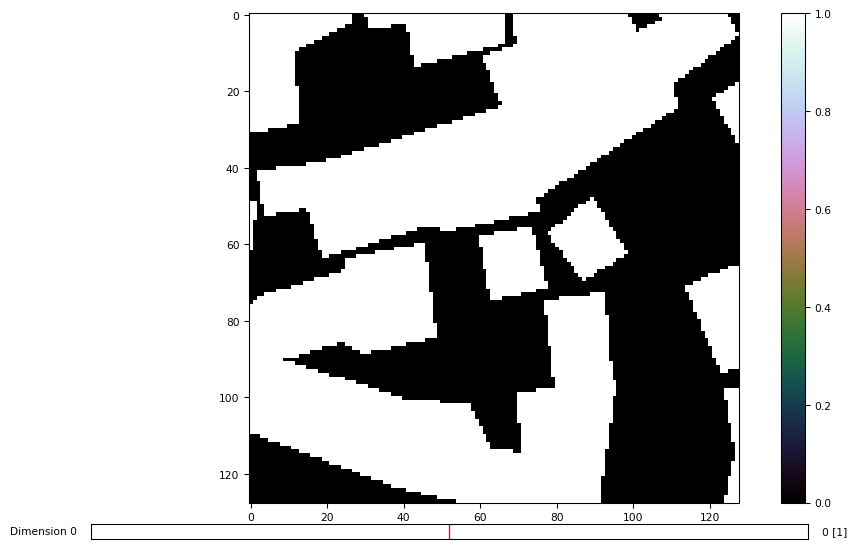

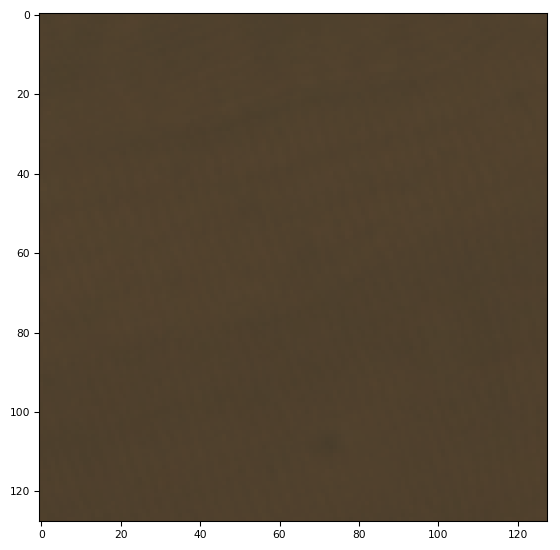

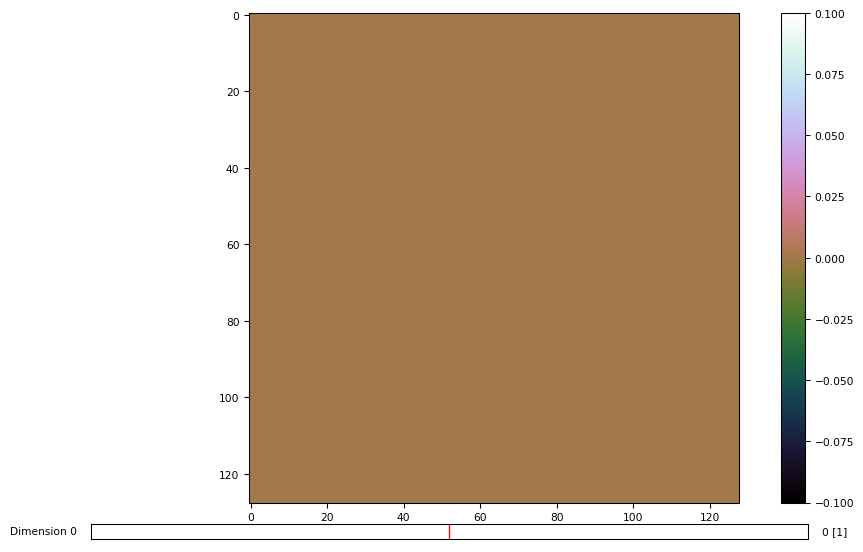

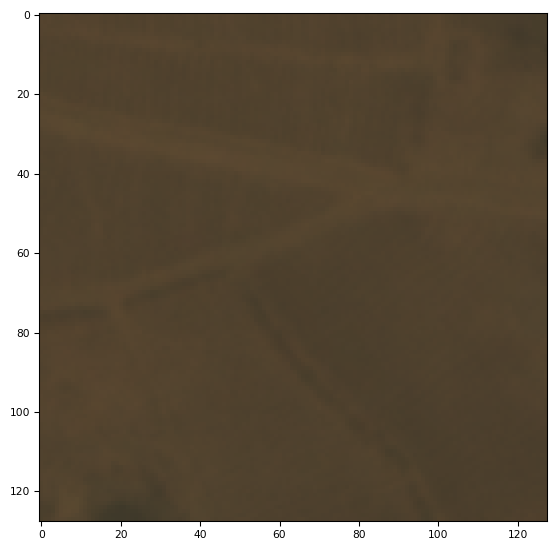

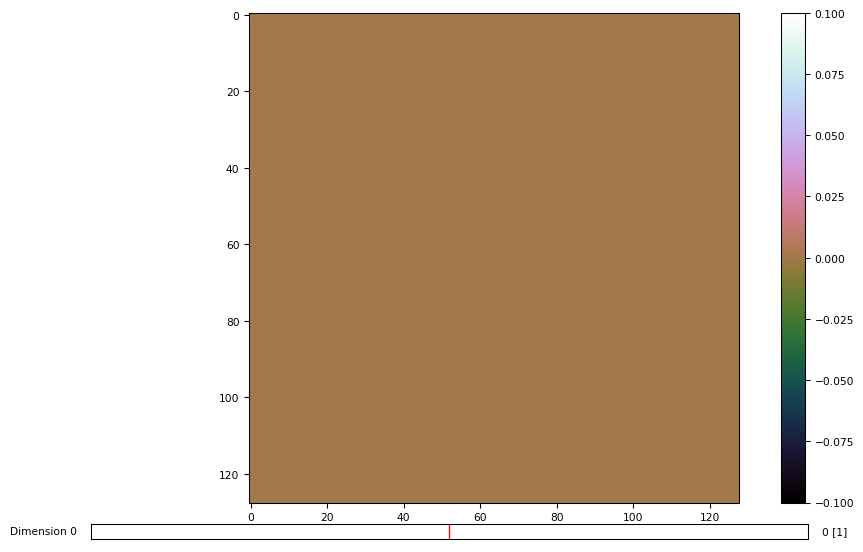

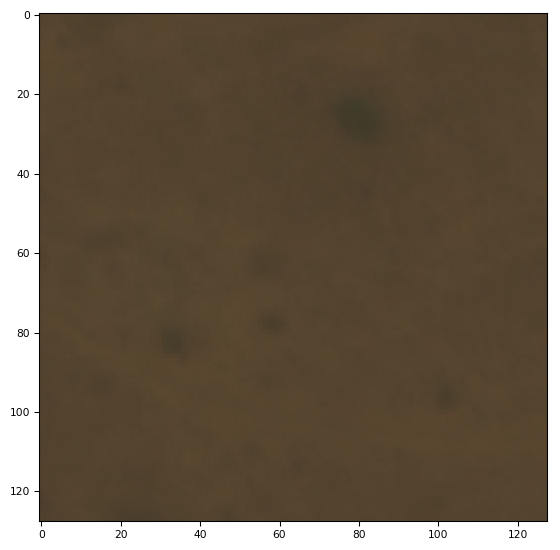

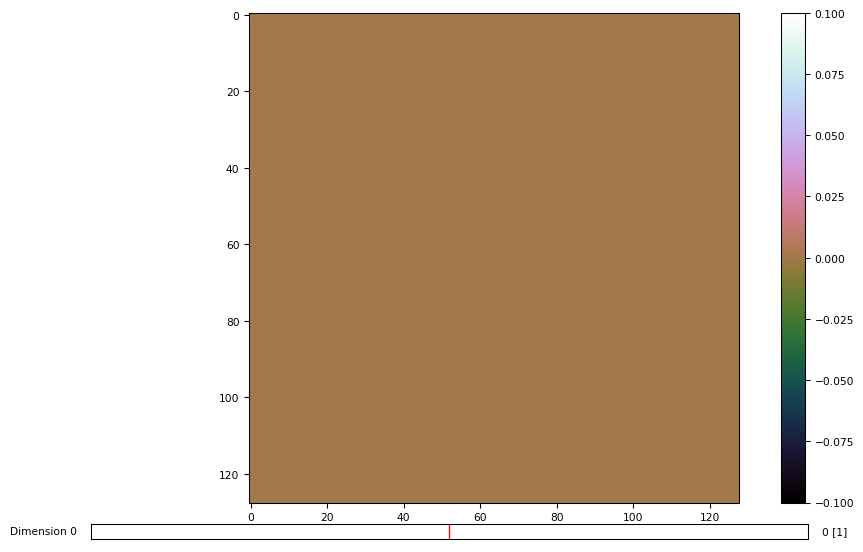

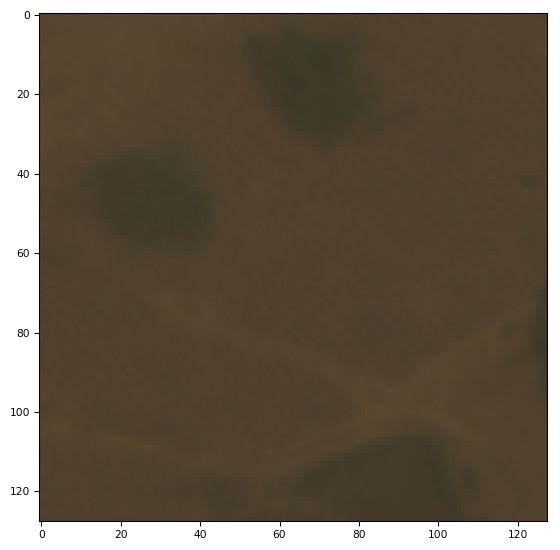

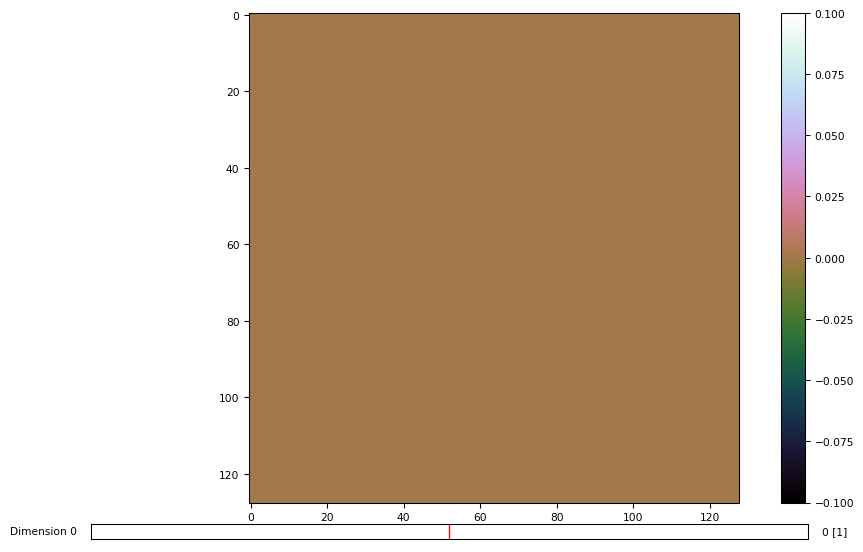

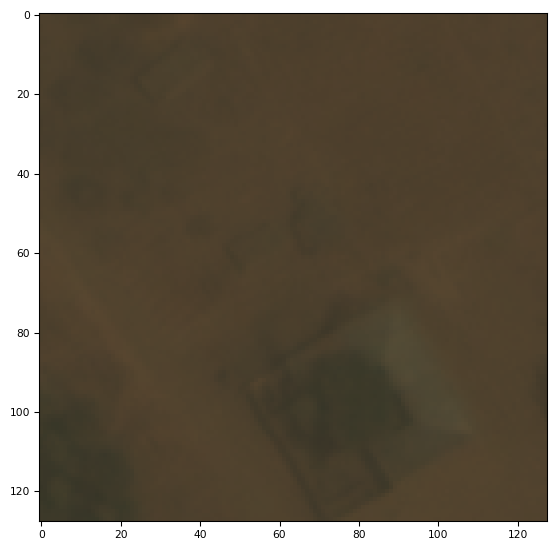

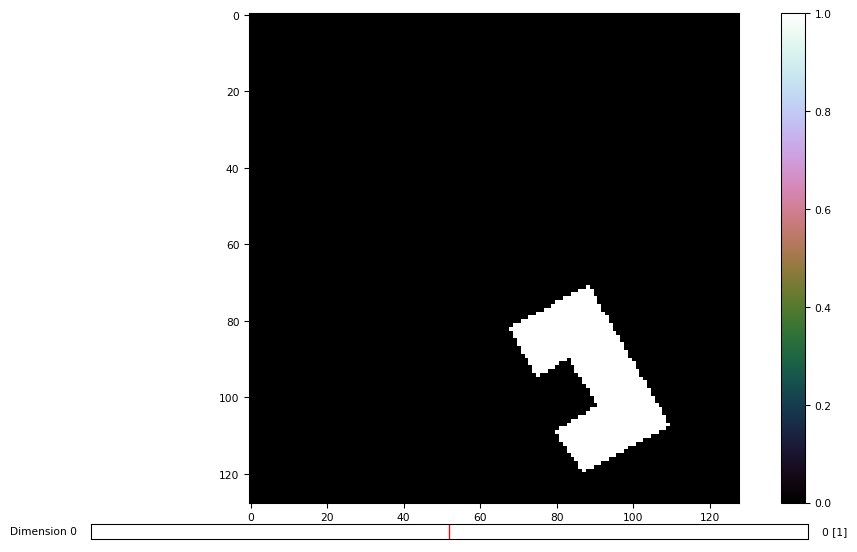

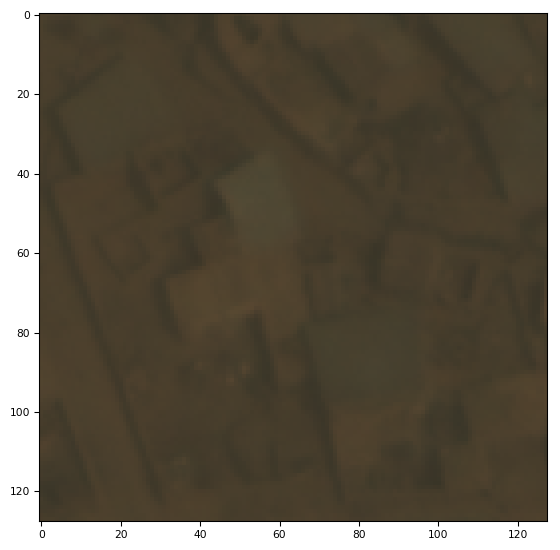

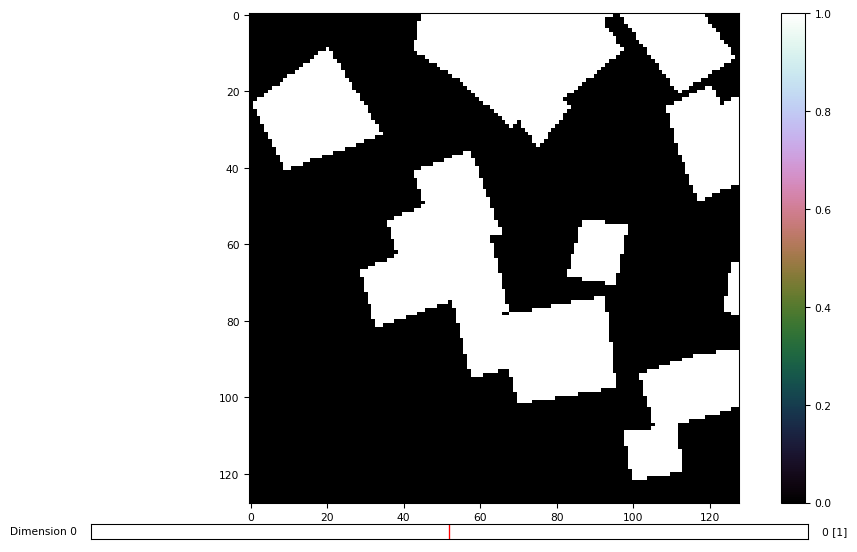

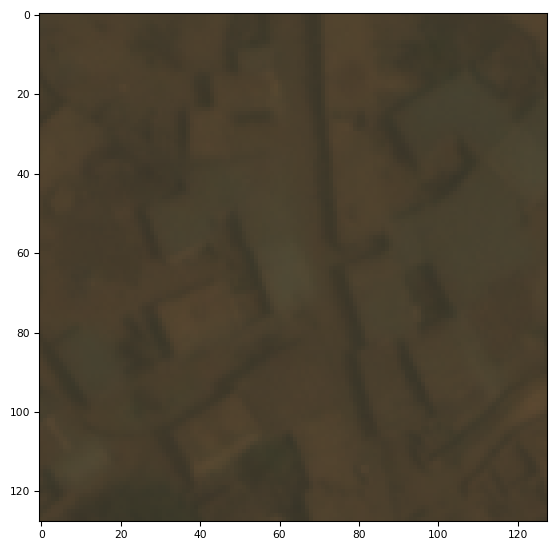

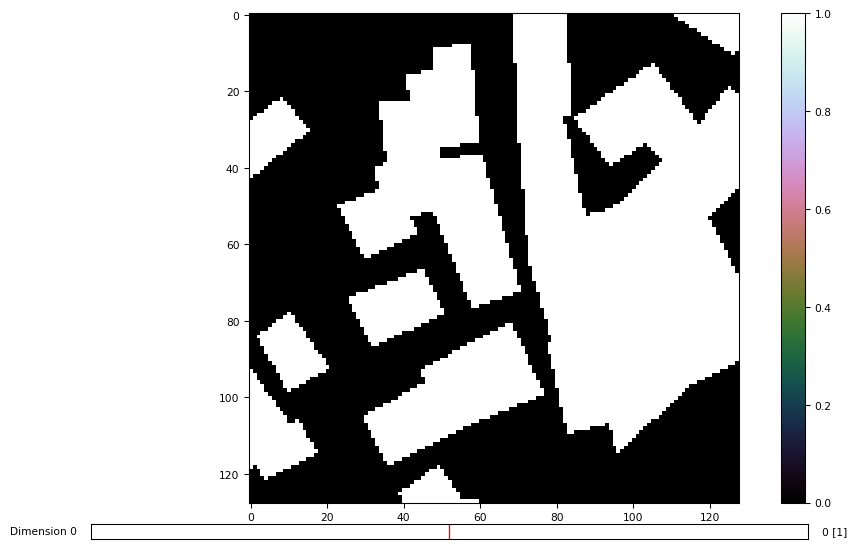

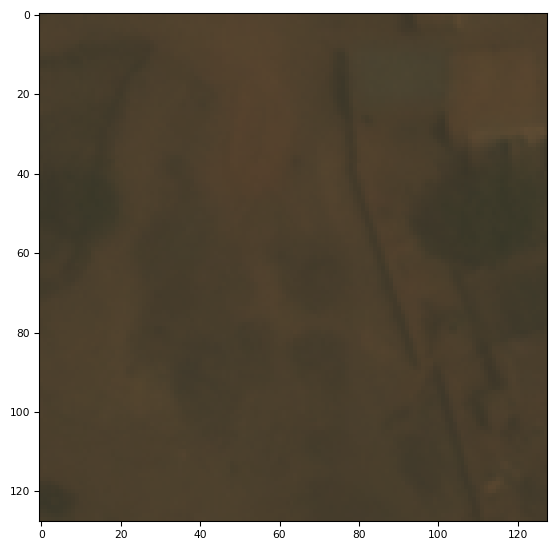

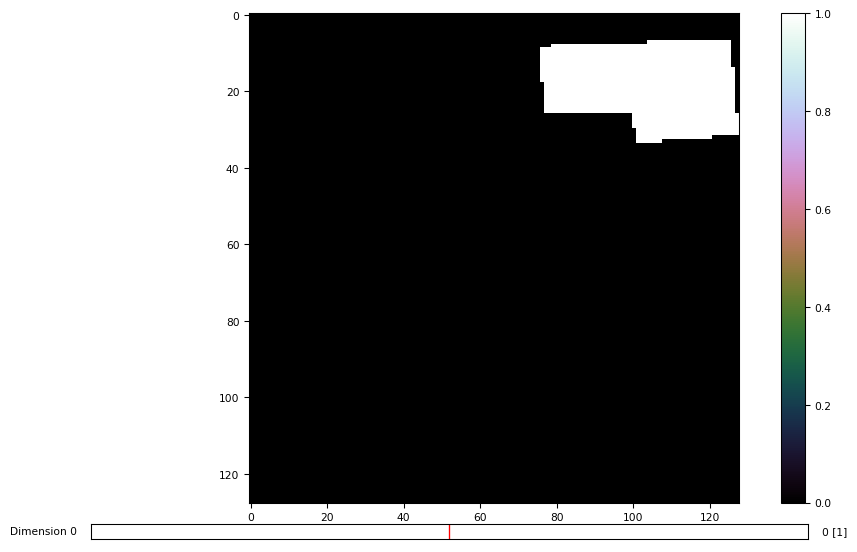

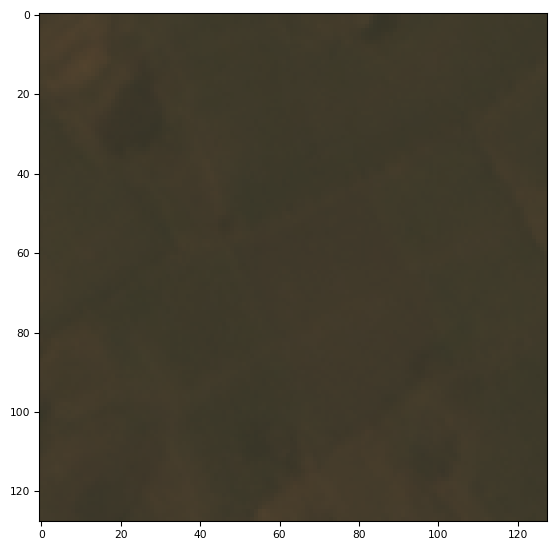

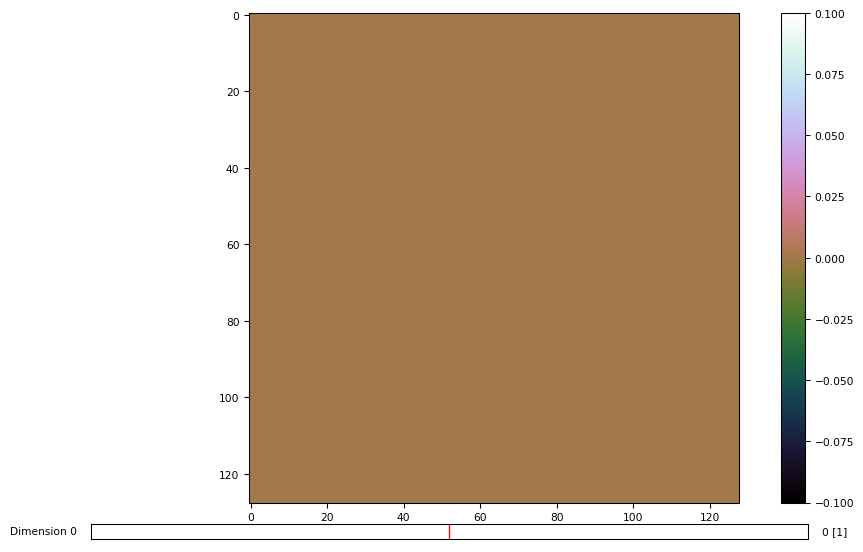

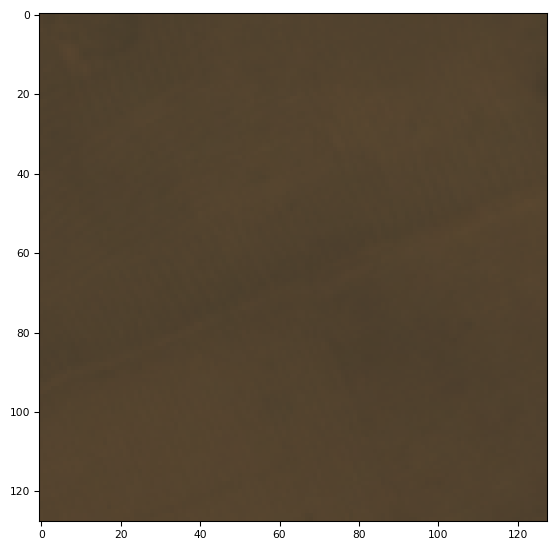

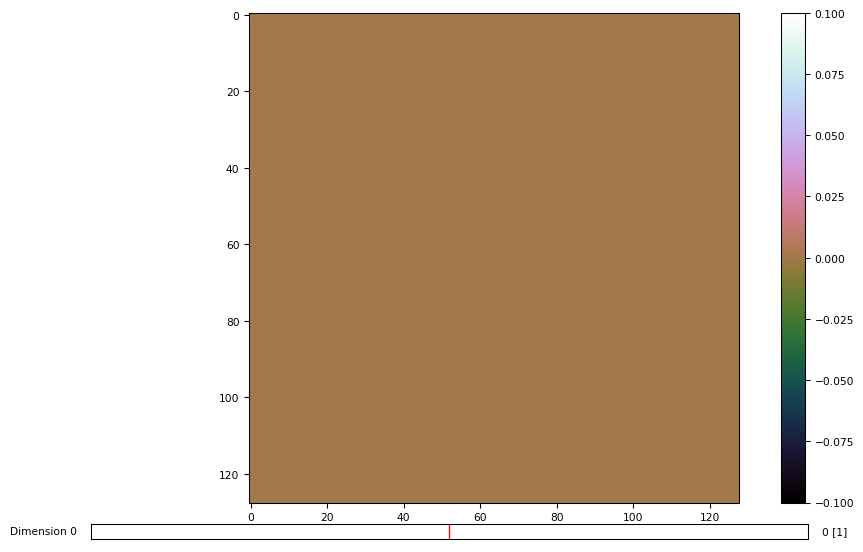

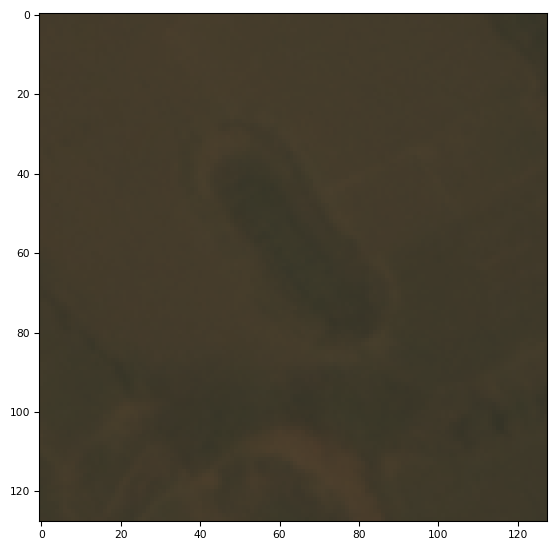

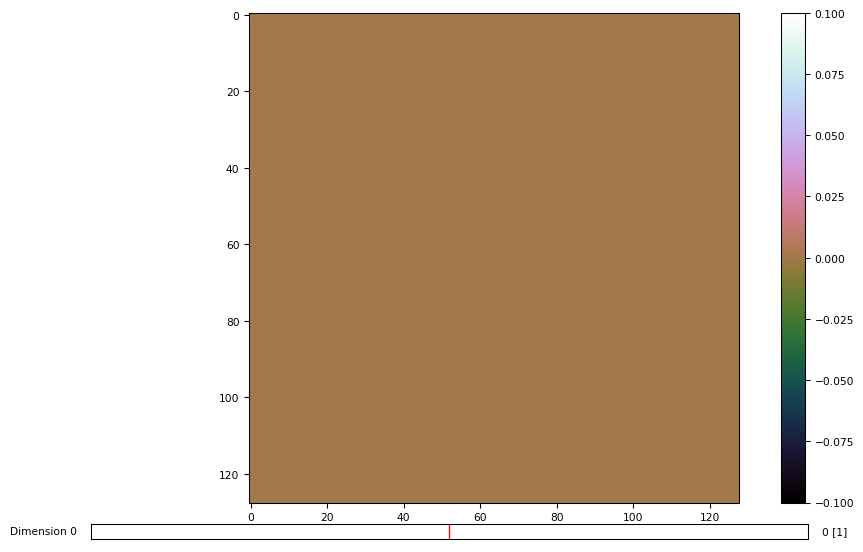

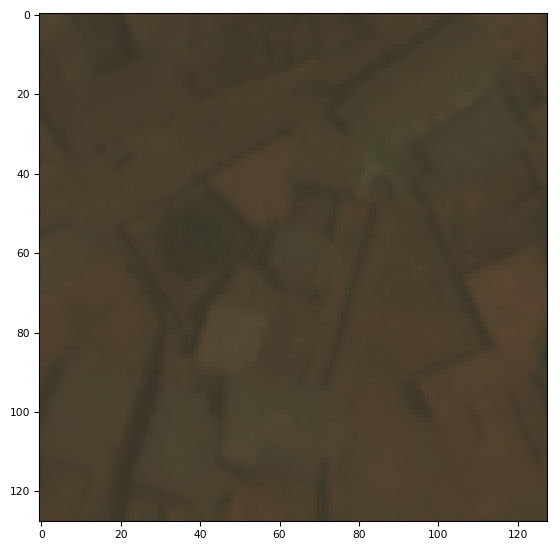

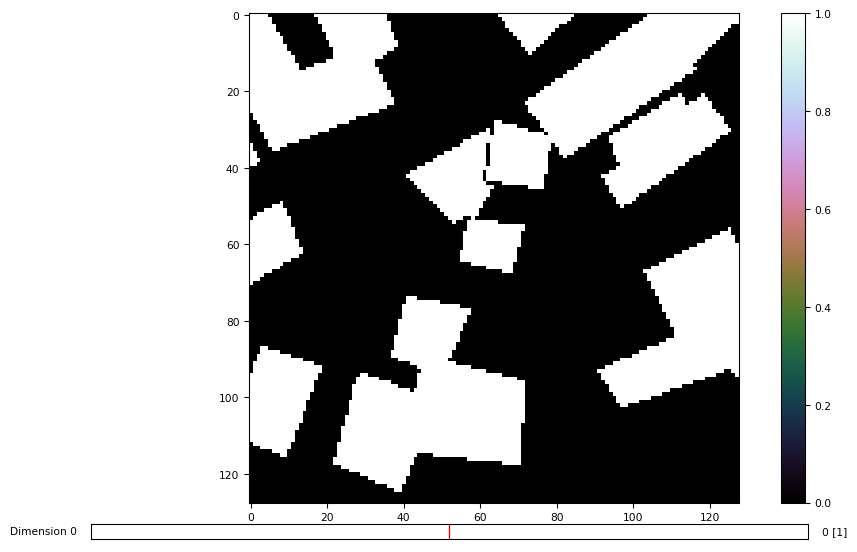

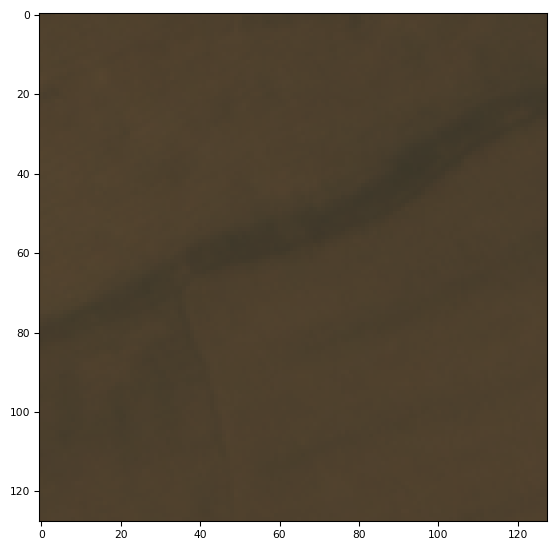

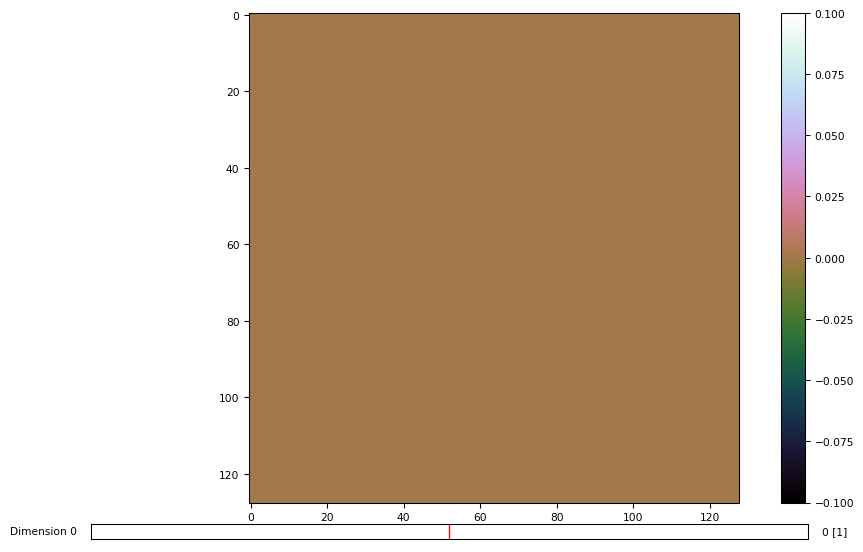

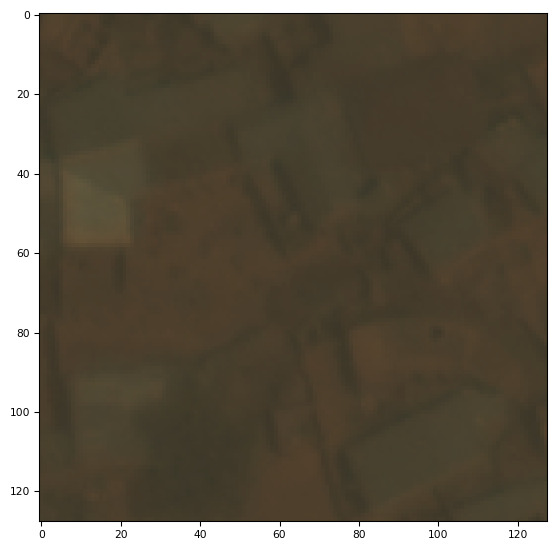

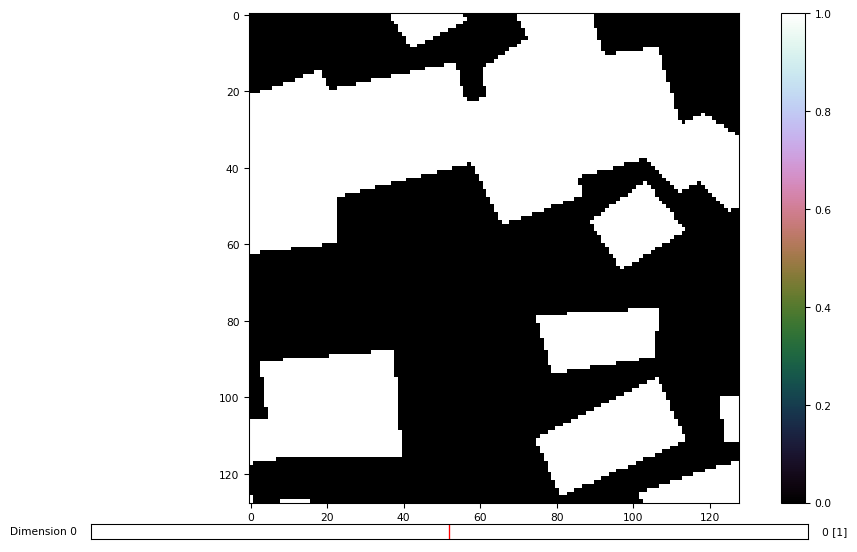

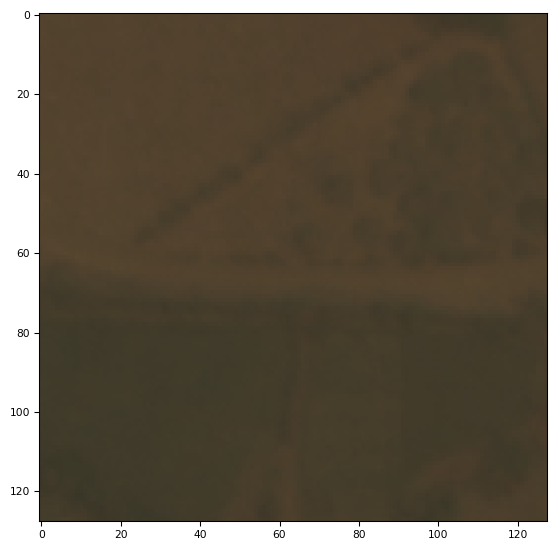

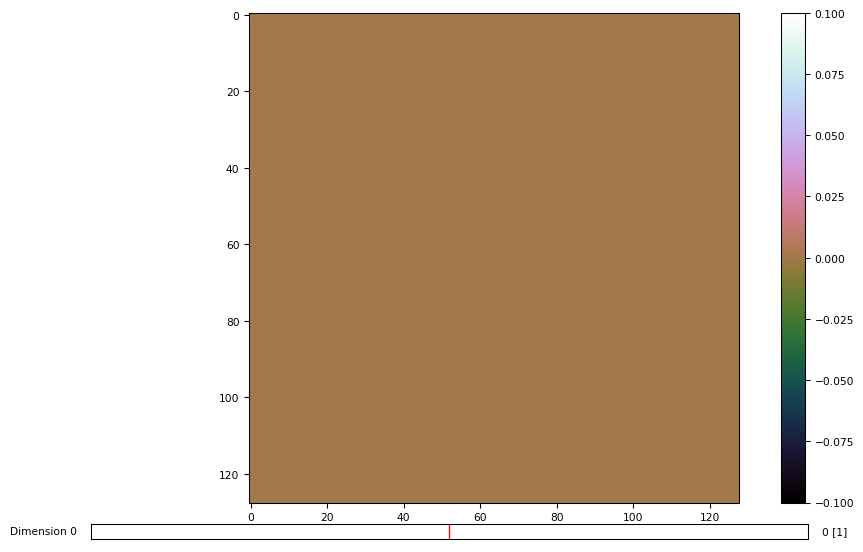

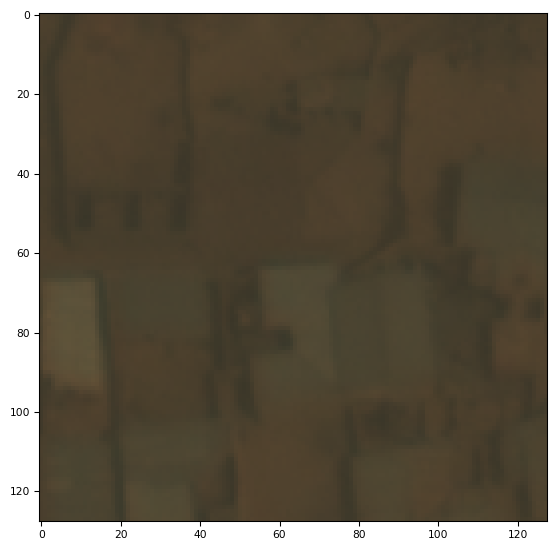

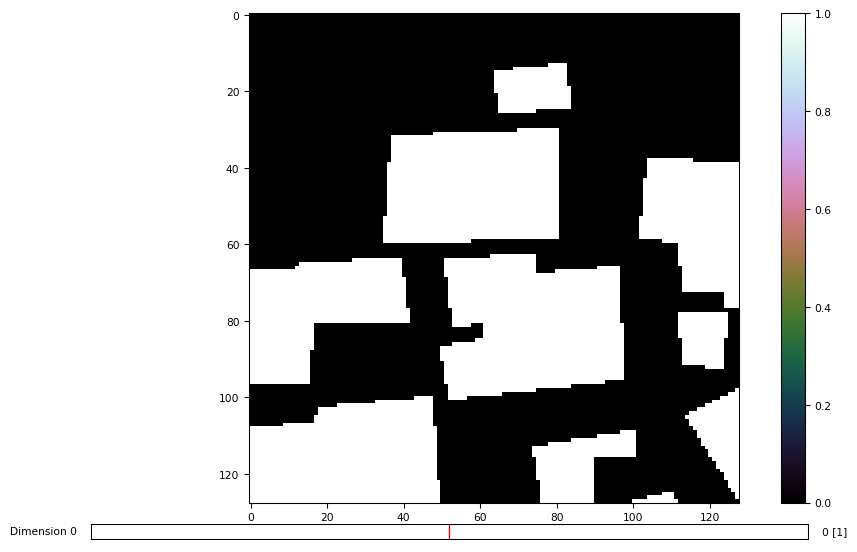

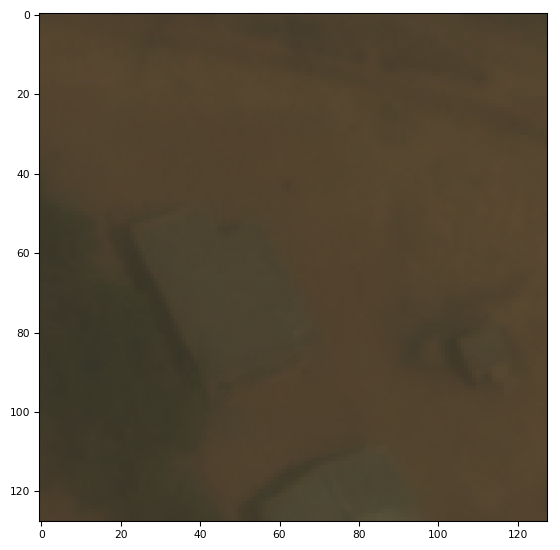

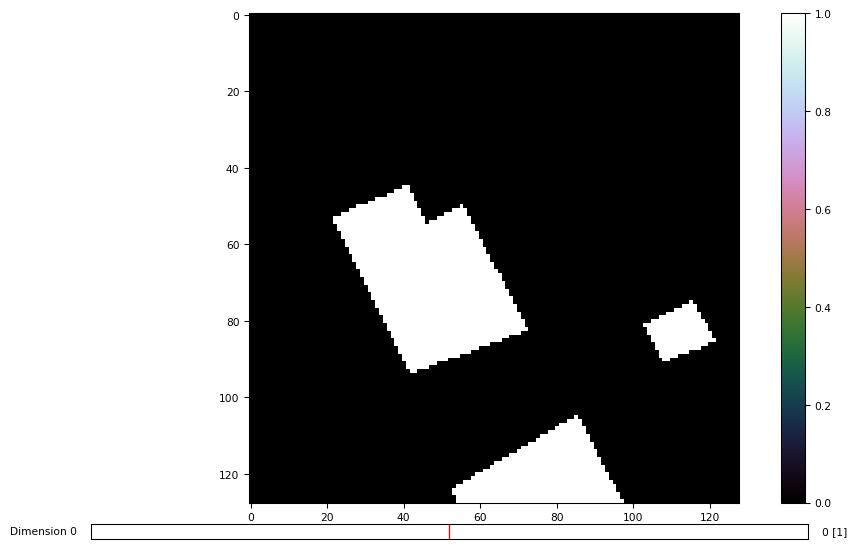

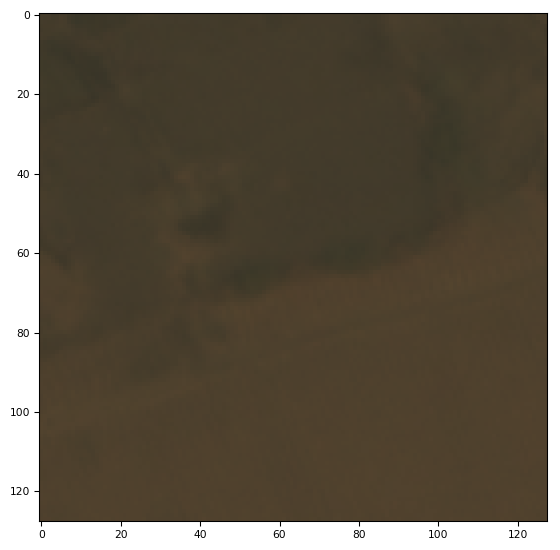

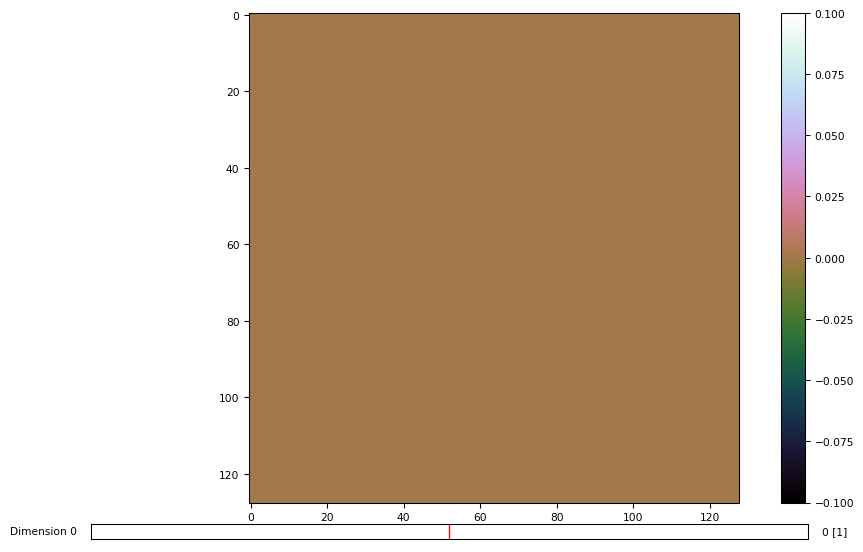

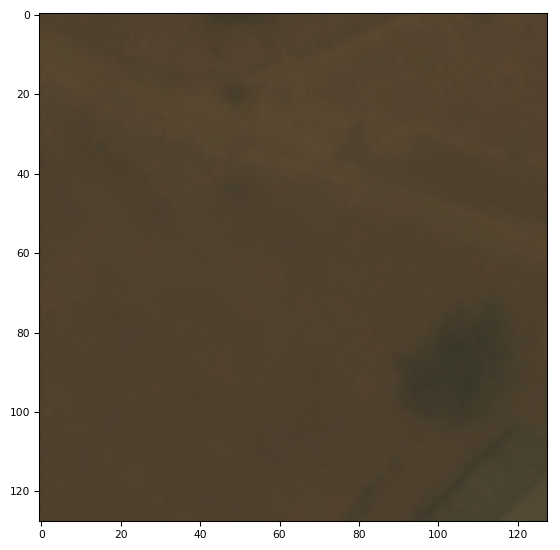

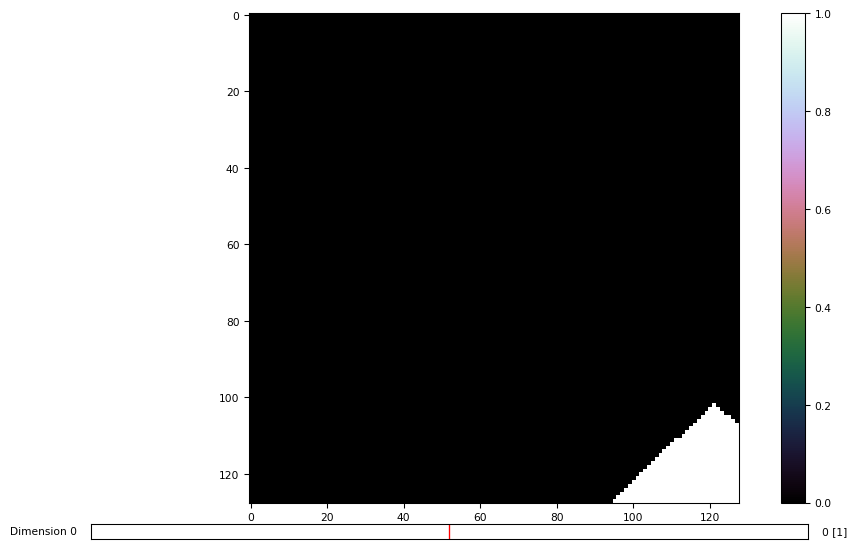

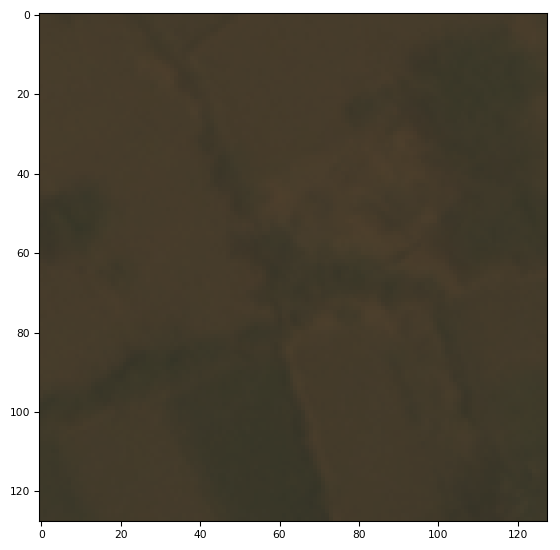

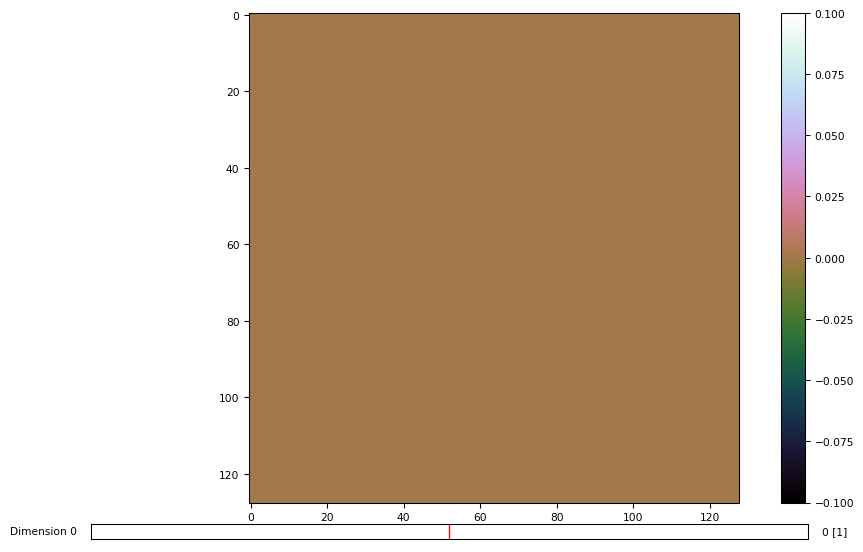

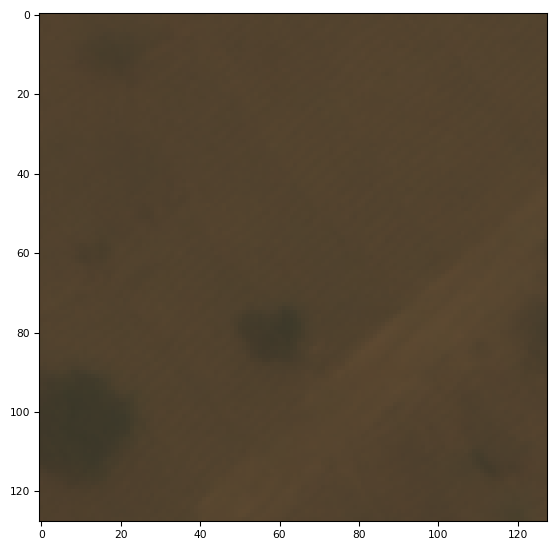

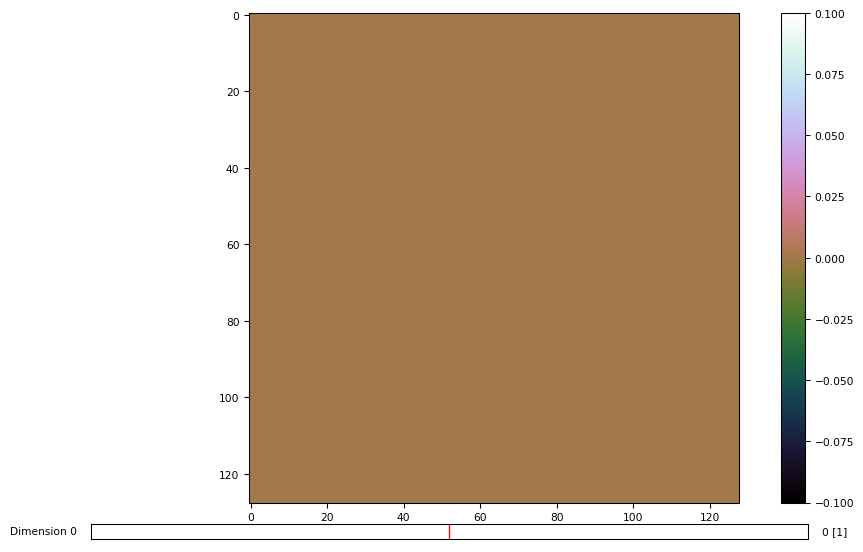

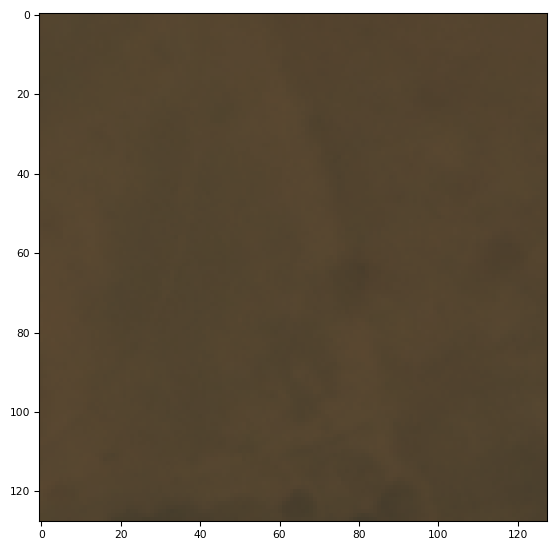

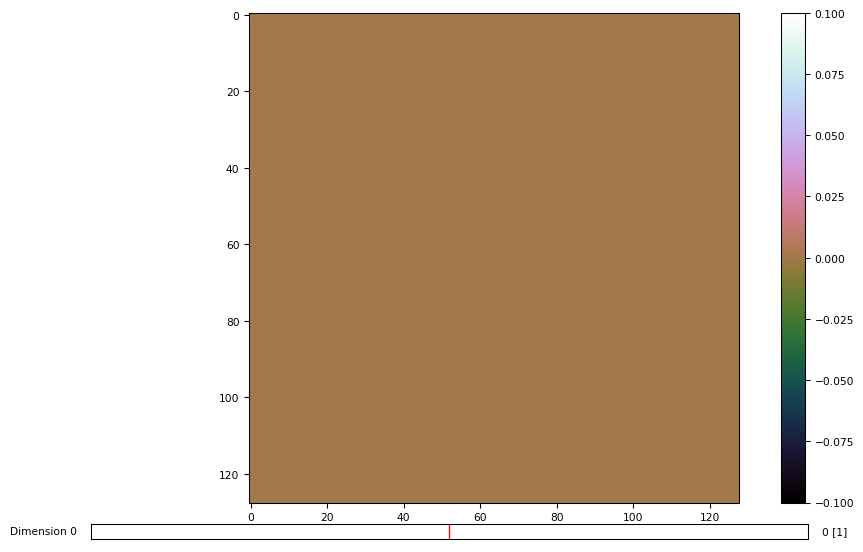

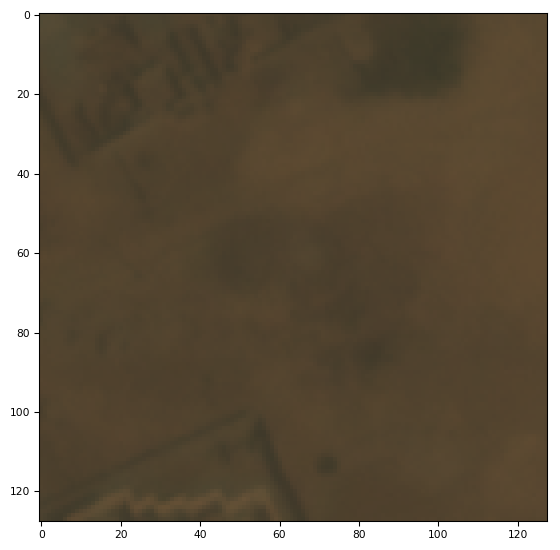

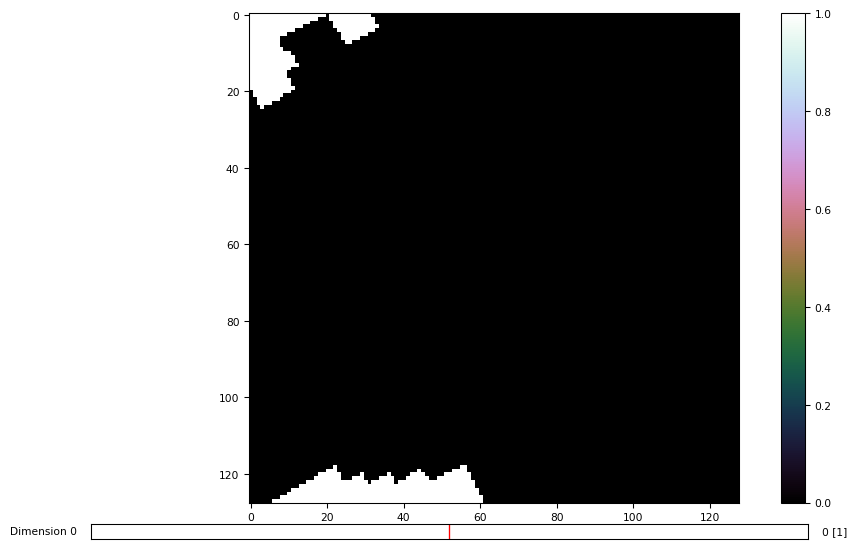

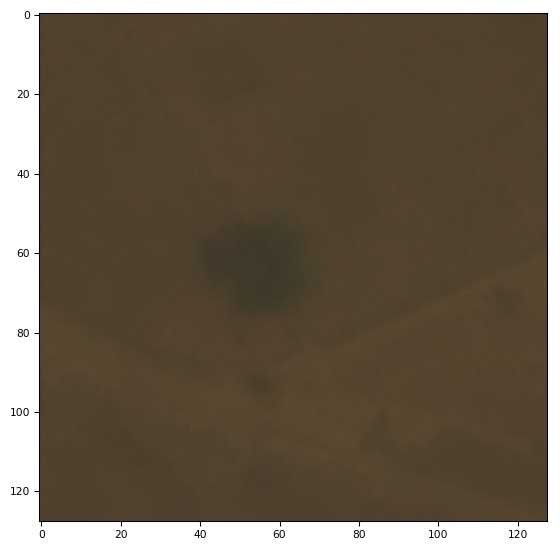

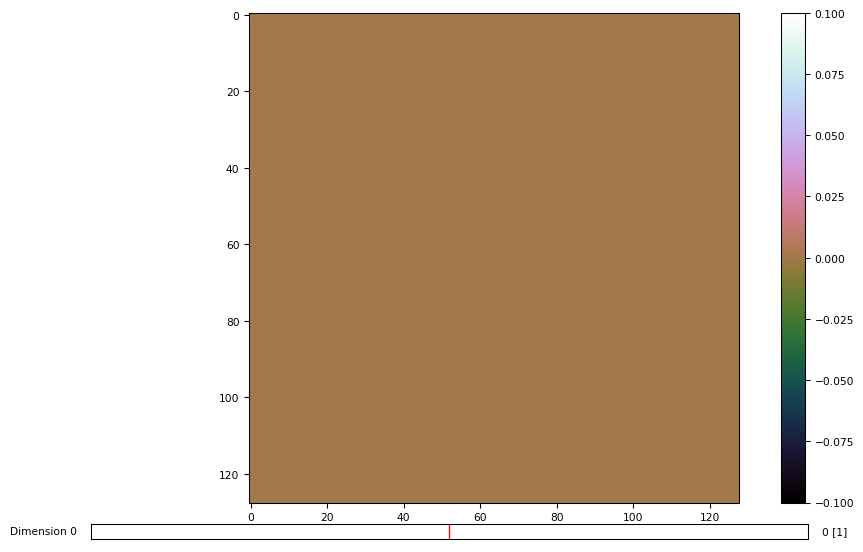

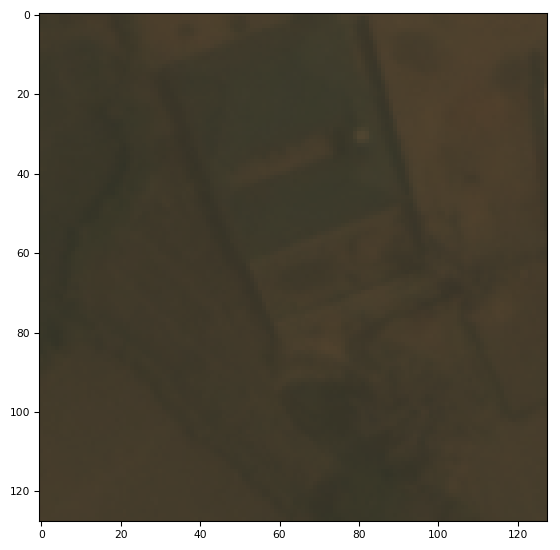

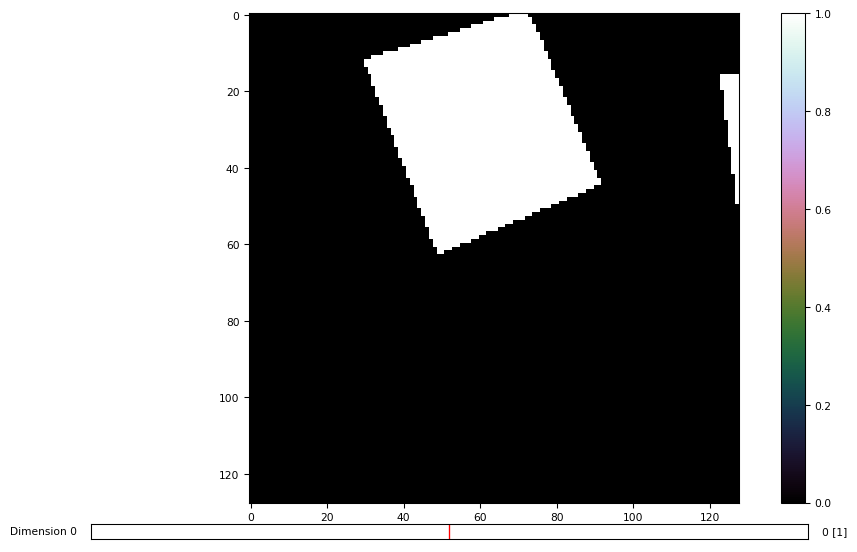

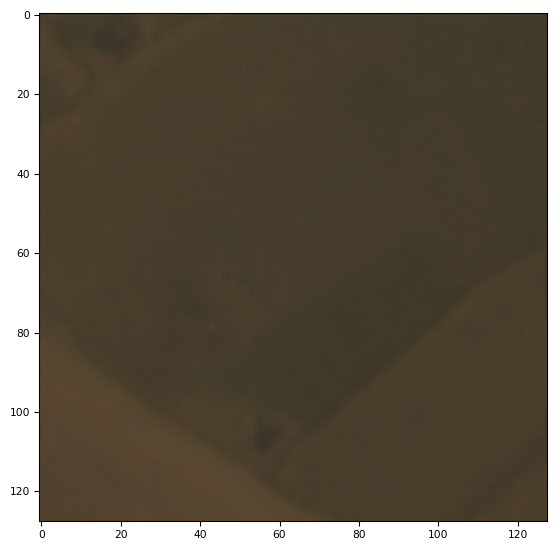

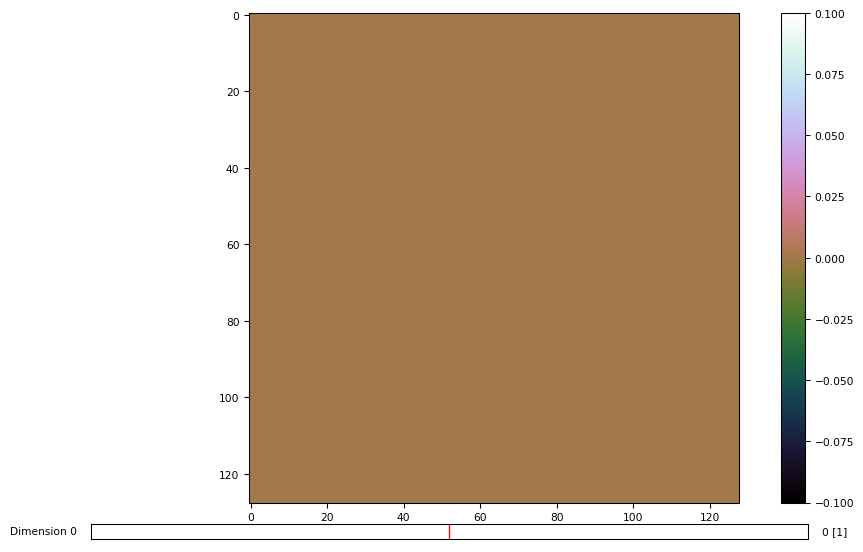

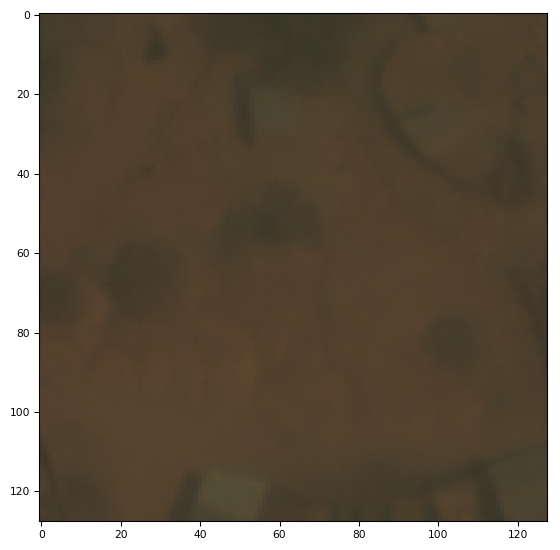

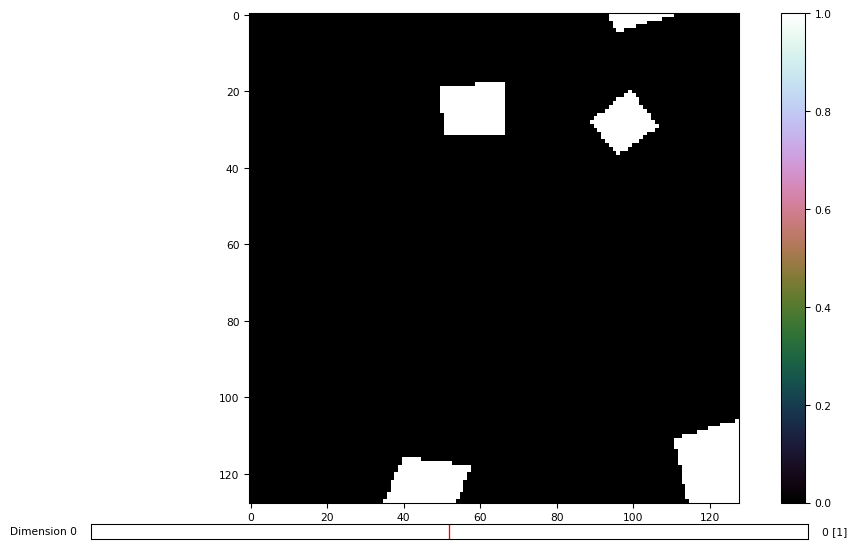

In [36]:
val_imgs = os.listdir('Dataset/DSTL/fly2/debug/train/imgs/')
val_imgs = ['Dataset/DSTL/fly2/debug/train/imgs/'+i for i in val_imgs]
val_masks = os.listdir('Dataset/DSTL/fly2/debug/train/masks/')
val_masks = ['Dataset/DSTL/fly2/debug/train/masks/'+i for i in val_masks]
print(val_masks, val_imgs)
for i in range (len(val_imgs)):
    img = tiff.imread(val_imgs[i])
    tiff.imshow(img)
    plt.show()
    mask = tiff.imread(val_masks[i])
    tiff.imshow(mask[:,:,0])
    plt.show()

/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


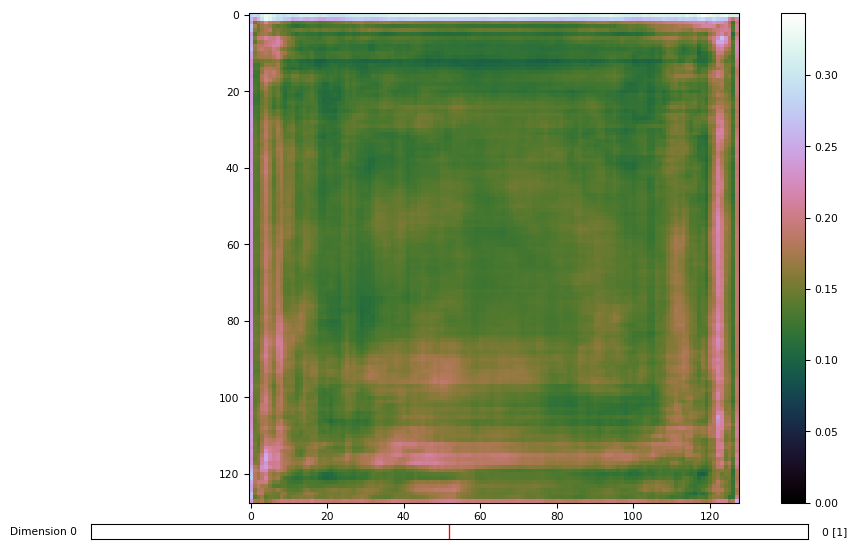

In [39]:
tiff.imshow(model.predict(np.array([img])))
plt.show()

In [5]:
classes = [0, 1,4,5]
scales = [1, 0.5]
histories = {}

for cls in classes:
    for scale in scales:

        # Unet v1.1 with batchnorms
        inputs = Input((256,256,3))
        bn1 = BatchNormalization()(inputs)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bn1)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

        up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis =3 )
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

        conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv9)

        model = Model(inputs=inputs, outputs=conv10, name = 'Unet')
        #model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ 'accuracy'])
        print(model.summary())

        optimizer = keras.optimizers.SGD(lr=0.003)
        model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=['accuracy', iou_metric])
        batch_size = 9
        # cls = 0
        # scale = 1
        training_generator = BatchGeneratorFly(batch_size = batch_size)
        training_generator.masks_analysis(masks)
        generator_1 = training_generator.generate(imgs, masks, cls, scale)
        
#         generator_2 = training_generator.generate(imgs, masks, cls, scale)
        validation_generator = BatchGeneratorFly(batch_size = batch_size)
        validation_generator.masks_analysis(masks)
        generator_2 = validation_generator.generate(imgs, masks, cls, scale)
        
        #validation_generator = BatchGeneratorFly(DF, GS, batch_size = batch_size).generate(imgs, masks, cls, scale)

        history = model.fit_generator(generator = generator_1,
                            steps_per_epoch =500,# len(X_train)//batch_size,
                            validation_data = generator_2,
                            validation_steps =50,# len(X_train)//batch_size, 
                            verbose = True,epochs= 10)
        key = 'NN_histories/1___'+str(cls) + '_'+str(scale)
        #print(key)
        histories[key] = history.history
        with open (key+'.pkl', 'wb') as f:
            pickle.dump(history.history, f)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_20 (BatchNor (None, 256, 256, 3)   12          input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 256, 256, 32)  896         batch_normalization_20[0][0]     
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 256, 256, 32)  9248        conv2d_20[0][0]                  
___________________________________________________________________________________________

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/user/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-3-15a5b610d019>", line 31, in generate
    img_patches, mask_patches = map_obj.get_class_patches(cls, self.batch_size, patch_size = (self.dim_x, self.dim_y), scale = scale, aug = False)
  File "/home/user/Documents/Parunin/remote_sensing/utils/MapObject.py", line 120, in get_class_patches
    _, contours, hierarchy = cv2.findContours( self.mask[:,:,cls]*255, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cv2.error: /io/opencv/modules/imgproc/src/contours.cpp:199: error: (-210) [Sta

StopIteration: 

In [ ]:
pred = split_image('Dataset/DSTL/fly2/train/images/6140_1_2.tif', model)

In [40]:
pred.shape

(3348, 3396, 1)

/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


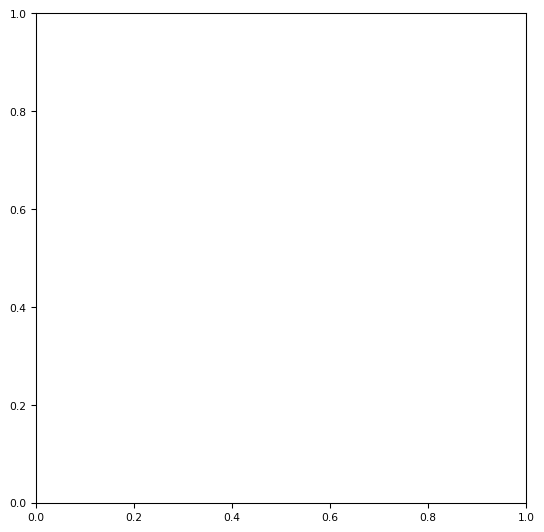

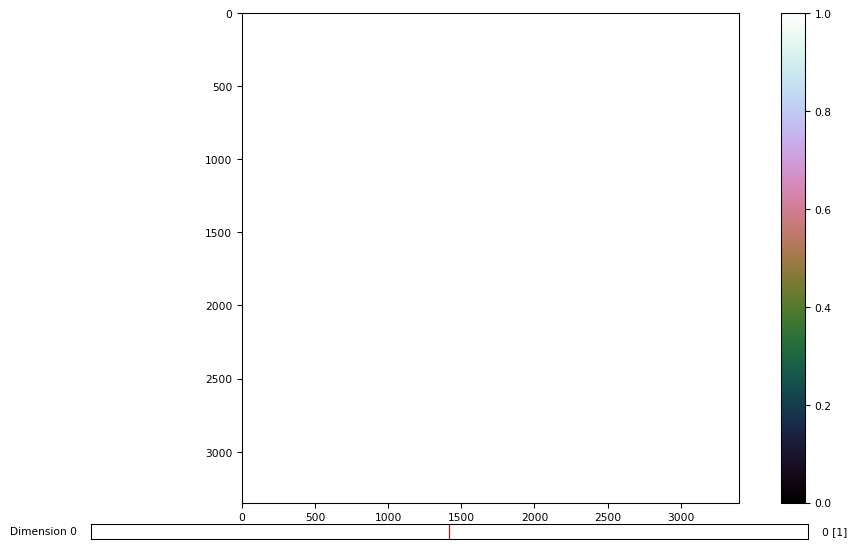

In [41]:
tiff.imshow(pred[:,:,0])
plt.show()